# **MSc Data Science thesis project: Micromobility vehicle parking**
## **Pre-processing, exploring and merging the neighborhood characteristics**

### **1 Import libraries**

In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeos
from shapely.geometry.collection import GeometryCollection
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
import seaborn as sn
%matplotlib inline
import seaborn as sns
from datetime import datetime
import folium

from scipy import stats
import sklearn

# Set main directories
main_path = '...'
neighborhood_characteristics_path = main_path + "neighborhood_characteristics/"
shapefiles_path = main_path + '/vehicle_parking_shapefiles/'


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

C:\Users\jfieb\anaconda3\envs\py37\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### **2 Read the data**

In [2]:
vehicle_parking_2019 = pd.read_csv(main_path + 'vehicle_parking_2019_merged_all.csv',delimiter=',',encoding = 'utf-8-sig')
vehicle_parking_2020 = pd.read_csv(main_path + 'vehicle_parking_2020_merged_all.csv',delimiter=',',encoding = 'utf-8-sig')
vehicle_parking_2021 = pd.read_csv(main_path + 'vehicle_parking_2021_merged_all.csv',delimiter=',',encoding = 'utf-8-sig')

In [3]:
# Read the shapefiles for each year
shapefile_2019 = gpd.read_file(shapefiles_path + '/sct_ams_fiets_poly_2019_v2')
shapefile_2020 = gpd.read_file(shapefiles_path + '/sct_ams_fiets_poly_2020_v1/sct_ams_fiets_poly_2020_v1')
shapefile_2021 = gpd.read_file(shapefiles_path + '/sct_ams_fiets_poly_2021/')

shapefile_2019 = shapefile_2019.rename(columns={"Alias_2018": "section_2018", "straat":"street"})
shapefile_2020 = shapefile_2020.rename(columns={"Alias_2018": "section_2018", "straat":"street"})
shapefile_2021 = shapefile_2021.rename(columns={"id": "section_2018", "straat":"street"})

In [4]:
vehicle_parking_2019 = shapefile_2019[['section_2018','geometry']].merge(vehicle_parking_2019.drop(['geometry'], axis=1), how='inner', on=['section_2018'])
vehicle_parking_2020 = shapefile_2020[['section_2018','geometry']].merge(vehicle_parking_2020.drop(['geometry'], axis=1), how='inner', on=['section_2018'])
vehicle_parking_2021 = shapefile_2021[['section_2018','geometry']].merge(vehicle_parking_2021.drop(['geometry'], axis=1), how='inner', on=['section_2018'])

# Delete entries with missing geometry
vehicle_parking_2019.dropna(subset=['geometry'], inplace=True)
vehicle_parking_2020.dropna(subset=['geometry'], inplace=True)
vehicle_parking_2021.dropna(subset=['geometry'], inplace=True)

vehicle_parking_2019['area'] = vehicle_parking_2019.to_crs({'init': 'epsg:32631'}).geometry.area
vehicle_parking_2020['area'] = vehicle_parking_2020.to_crs({'init': 'epsg:32631'}).geometry.area
vehicle_parking_2021['area'] = vehicle_parking_2021.to_crs({'init': 'epsg:32631'}).geometry.area

vehicle_parking_2019['geometry_line'] = vehicle_parking_2019['geometry'].boundary # for better visualisation
vehicle_parking_2020['geometry_line'] = vehicle_parking_2020['geometry'].boundary # for better visualisation
vehicle_parking_2021['geometry_line'] = vehicle_parking_2021['geometry'].boundary # for better visualisation

In [6]:
parking_data = [vehicle_parking_2019, vehicle_parking_2020, vehicle_parking_2021]
vehicle_parking = pd.concat(parking_data)
vehicle_parking.shape

(98026, 236)

In [5]:
# Read data with the city districts
city_division_path = main_path + 'city_division/'

neighborhoods = gpd.read_file(city_division_path + 'neighborhoods.json')
quarters = gpd.read_file(city_division_path + 'quarters.json')
areas = gpd.read_file(city_division_path + 'areas.json')
districts = gpd.read_file(city_division_path + 'districts.json')

neighborhoods.rename(columns={"Buurtnaam":"neighborhood_name", "Buurtcode":"neighborhood_code", "Oppervlakte_m2": "neighborhood_m2"}, inplace = True)
quarters.rename(columns={"Wijknaam":"quarter_name", "Wijkcode":"quarter_code", "Oppervlakte_m2": "quarter_m2"}, inplace = True)
areas.rename(columns={"Gebied25_naam":"area_name", "Opp_m2": "area_m2"}, inplace = True)
districts.rename(columns={"Stadsdeelnaam":"district_name", "Stadsdeelcode":"district_code", "Oppervlakte_m2": "district_m2"}, inplace = True)

In [17]:
def merge_with_districts(df):
    # Merge vehicle parking count data with information about the city districts
    df = gpd.sjoin(df.to_crs({'init': 'epsg:3857'}), neighborhoods[['neighborhood_name','neighborhood_code','neighborhood_m2','geometry']].to_crs({'init': 'epsg:3857'}), how='left',  lsuffix='vehicle', rsuffix='neighborhoods')
    df = gpd.sjoin(df.to_crs({'init': 'epsg:3857'}), quarters[['quarter_name','quarter_code','quarter_m2','geometry']].to_crs({'init': 'epsg:3857'}), how='left',  lsuffix='vehicle', rsuffix='quarters')
    df = gpd.sjoin(df.to_crs({'init': 'epsg:3857'}), areas[['area_name','area_m2','geometry']].to_crs({'init': 'epsg:3857'}), how='left',  lsuffix='vehicle', rsuffix='areas')
    df = gpd.sjoin(df.to_crs({'init': 'epsg:3857'}), districts[['district_name','district_code','district_m2','geometry']].to_crs({'init': 'epsg:3857'}), how='left',  lsuffix='vehicle', rsuffix='districts')
    df.drop(['index_neighborhoods','index_quarters','index_areas','index_districts'], inplace=True, axis=1)
    df.drop_duplicates(subset=['geometry'], inplace=True)
#     df.drop_duplicates(subset=['year','section_2018','geometry'], inplace=True)
    return df

In [9]:
vehicle_parking.drop(['neighborhood_name', 'neighborhood_code','neighborhood_m2',
                      'quarter_name','quarter_code','quarter_m2',
                     'area_name','area_m2',
                     'district_name','district_code','district_m2'], inplace=True, axis=1)

vehicle_parking = merge_with_districts(vehicle_parking)

In [2]:
# Read neighborhood data
function_map = gpd.read_file(neighborhood_characteristics_path + 'function_map.json')
function_mix = gpd.read_file(neighborhood_characteristics_path + 'function_mix.json')
sidewalks = gpd.read_file(neighborhood_characteristics_path + "final_output_segments_all.geojson")
tram_metro = gpd.read_file(neighborhood_characteristics_path + 'tram_metro_2021.json')
shopping_areas = gpd.read_file(neighborhood_characteristics_path + 'shopping_areas.json')
horeca = gpd.read_file(neighborhood_characteristics_path + 'horeca.json')

### **3 Pre-process and explore the data on neighborhood characteristics**

#### Sidewalk width

In [4]:
print(sidewalks.shape)
sidewalks.head()

(291979, 7)


id final_color full_width full_width_color  object_id obstacle_free_width  \
0  0        grey   1.8-2.9m       lightgreen          0             unknown   
1  1        grey   1.8-2.9m       lightgreen          1             unknown   
2  2        grey   1.8-2.9m       lightgreen          2             unknown   
3  3        grey   1.8-2.9m       lightgreen          3             unknown   
4  4        grey   1.8-2.9m       lightgreen          4             unknown   

                                            geometry  
0  LINESTRING (4.77585 52.34854, 4.77586 52.34854...  
1  LINESTRING (4.77694 52.34810, 4.77695 52.34810...  
2  LINESTRING (4.77803 52.34765, 4.77804 52.34765...  
3  LINESTRING (4.77912 52.34720, 4.77913 52.34720...  
4  LINESTRING (4.78021 52.34675, 4.78022 52.34675...

In [7]:
print(sidewalks.full_width.unique())
print(sidewalks.obstacle_free_width.unique())

['1.8-2.9m' '<0.9m' '>2.9m' '0.9-1.8m']
['unknown' '<0.9m' '0.9-1.8m' '>2.9m' '1.8-2.9m']


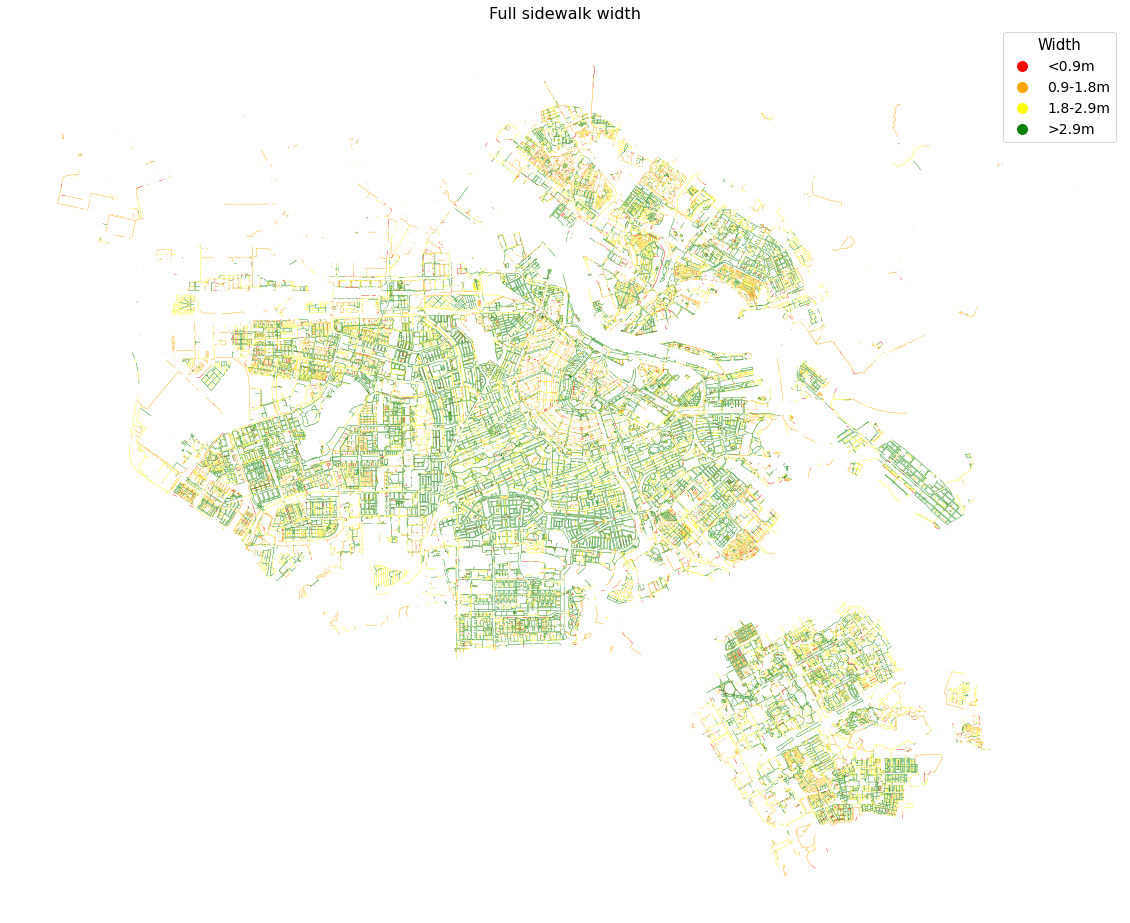

In [9]:
# Plot the full width

colorPalette = {'<0.9m': 'red',
               '0.9-1.8m': 'orange',
               '1.8-2.9m': 'yellow',
               '>2.9m' : 'green'}
fig, ax = plt.subplots(figsize=(20, 20))

for ctype, data in sidewalks.groupby('full_width'):
    # Define the color for each group using the dictionary
    color = colorPalette[ctype]

    # Plot each group using the color defined above
    data.plot(color=color,
                      ax=ax,
                      label=ctype,
                      linewidth = 0.4)
    
ax.set_title("Full sidewalk width", fontsize=16)
ax.set_axis_off()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='<0.9m',
                              markerfacecolor='red', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='0.9-1.8m',
                              markerfacecolor='orange', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='1.8-2.9m',
                              markerfacecolor='yellow', markersize=12),
                       Line2D([0], [0], marker='o', color='w', label='>2.9m',
                              markerfacecolor='green', markersize=12)]

ax.legend(handles=legend_elements, title='Width',prop={'size': 14}, title_fontsize=15)
plt.show()

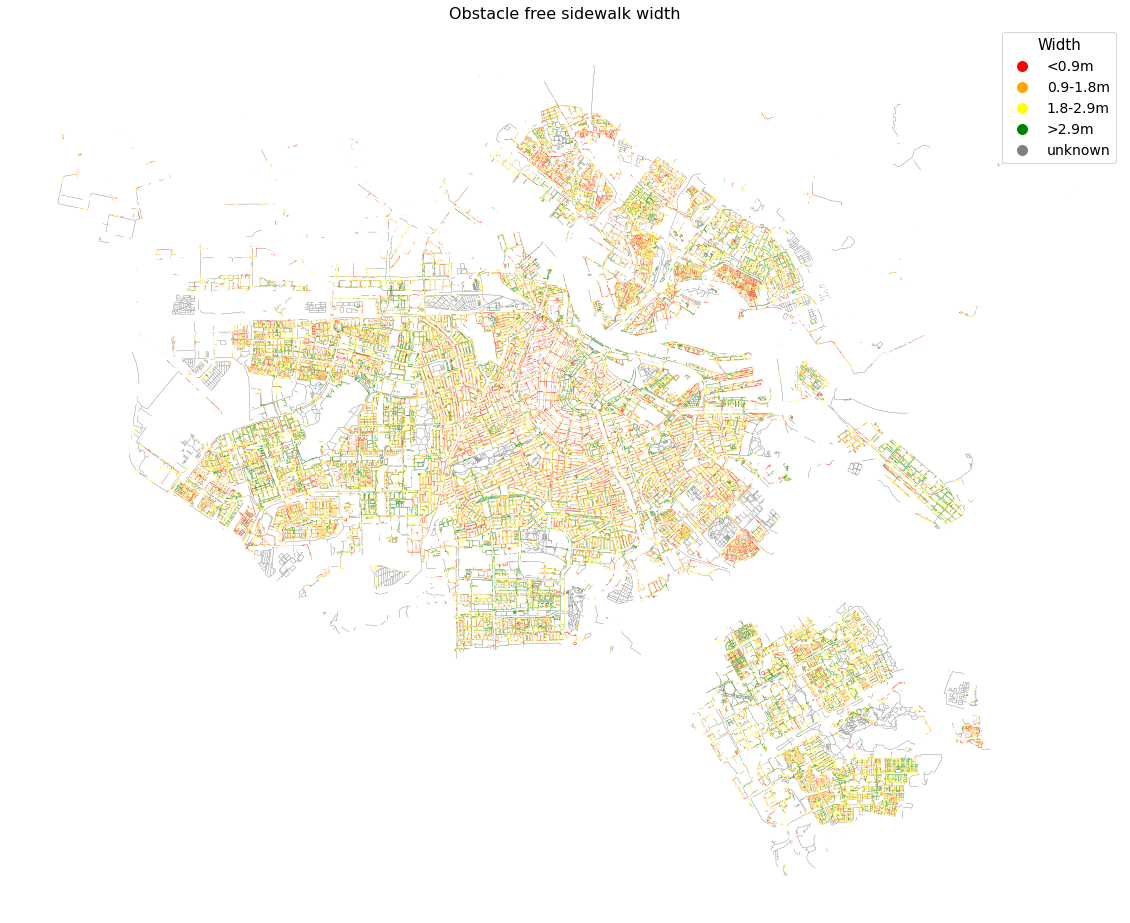

In [10]:
# Plot the obstacle free width

colorPalette = {'<0.9m': 'red',
               '0.9-1.8m': 'orange',
               '1.8-2.9m': 'yellow',
               '>2.9m' : 'green',
               'unknown' : 'gray'}
fig, ax = plt.subplots(figsize=(20, 20))

for ctype, data in sidewalks.groupby('obstacle_free_width'):
    # Define the color for each group using the dictionary
    color = colorPalette[ctype]

    # Plot each group using the color defined above
    data.plot(color=color,
                      ax=ax,
                      label=ctype,
                      linewidth = 0.4)
    
ax.set_title("Obstacle free sidewalk width", fontsize=16)
ax.set_axis_off()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='<0.9m',
                              markerfacecolor='red', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='0.9-1.8m',
                              markerfacecolor='orange', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='1.8-2.9m',
                              markerfacecolor='yellow', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='>2.9m',
                              markerfacecolor='green', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='unknown',
                              markerfacecolor='gray', markersize=12)]

ax.legend(handles=legend_elements, title='Width',prop={'size': 14}, title_fontsize=15)
plt.show()

In [13]:
# Add numerical feature with the sidewalk width (int)
conditions = [
    (sidewalks['obstacle_free_width'] == '<0.9m'),
    (sidewalks['obstacle_free_width'] == '0.9-1.8m'),
    (sidewalks['obstacle_free_width'] == '1.8-2.9m'),
    (sidewalks['obstacle_free_width'] == '>2.9m')]
choices = [0,90,180,290]
sidewalks['obstacle_free_width_cm'] = np.select(conditions, choices, default=None)
sidewalks['obstacle_free_width_cm'] = pd.to_numeric(sidewalks['obstacle_free_width_cm'])

# Add numerical feature with the sidewalk width (int)
conditions = [
    (sidewalks['full_width'] == '<0.9m'),
    (sidewalks['full_width'] == '0.9-1.8m'),
    (sidewalks['full_width'] == '1.8-2.9m'),
    (sidewalks['full_width'] == '>2.9m')]
choices = [0,90,180,290]
sidewalks['full_width_cm'] = np.select(conditions, choices, default=None)
sidewalks['full_width_cm'] = pd.to_numeric(sidewalks['full_width_cm'])

**Horeca**

In [6]:
print(horeca.shape)
horeca.head()

(4171, 26)


id  zaaknummer                                  zaaknaam  \
0   0          32                           Grillhouse Zion   
1   1          33  Regardz Meeting Center Planetarium Amste   
2   2          42                       Sporthal Gaasperdam   
3   3          48                            Duikelaar B.V.   
4   4          59                      Coffeeshop Chapiteau   

                        adres               zaakCategorie  \
0  Burgemeester Fockstraat 54                     Eethuis   
1            Kromwijkdreef 11  Restaurant met zaalverhuur   
2             Ravenswaaipad 5                    Onbekend   
3               Noordzijde 41                 Alcoholvrij   
4   Van Boetzelaerstraat 31-H                  Coffeeshop   

             zaakSpecificatie  begindatum   einddatum openingstijdenZoDoVan  \
0                     Eethuis  2022-03-25  2027-03-25                   7.0   
1  Restaurant met zaalverhuur  2020-11-01  2025-11-01                  07.0   
2                    Sporthal        None        None                  07.0   
3                   Lunchroom        None  2026-03-11                   7.0   
4                  Coffeeshop  2020-04-01  2023-04-01                  07.0   

  openingstijdenZoDoTot openingstijdenVrZaVan openingstijdenVrZaTot  \
0                   1.0                   7.0                   3.0   
1                  01.0                  07.0                  03.0   
2                  01.0                  07.0                  03.0   
3                   1.0                   7.0                   3.0   
4                  01.0                  07.0                  01.0   

  oTijdenTerrasZoDoVan oTijdenTerrasZoDoTot oTijdenTerrasVrZaVan  \
0                  7.0                 01.0                  7.0   
1                 07.0                 01.0                 07.0   
2                 None                 None                 None   
3                 None                 None                 None   
4                 None                 None                 None   

  oTijdenTerrasVrZaTot                                    terrasgeometrie  \
0                 02.0                                               None   
1                 02.0  {'type': 'MultiPolygon', 'coordinates': [[[[4....   
2                 None                                               None   
3                 None                                               None   
4                 None                                               None   

  postcode statusVergunning statusTijdelijkTerras toestemmingTijdelijkTerras  \
0   1063CV         Verleend                  None                       None   
1   1108JA         Verleend                  None                       None   
2   1106AW  Nog niet bekend                  None                       None   
3   1064GV         Verleend                  None                       None   
4   1051CT         Verleend                  None                       None   

  publBesluitTijdelijkTerras tijdelijkTerrasDetails  \
0                       None                   None   
1                       None                   None   
2                       None                   None   
3                       None                   None   
4                       None                   None   

  statusVerlengingTijdelijkTerras verlengingTijdelijkTerrasDetails  \
0                            None                             None   
1                            None                             None   
2                            None                             None   
3                            None                             None   
4                            None                             None   

                   geometry  
0  POINT (4.83282 52.38004)  
1  POINT (4.98768 52.31071)  
2  POINT (4.97826 52.29676)  
3  POINT (4.82226 52.37272)  
4  POINT (4.87306 52.38236)

In [7]:
horeca.zaakCategorie.unique()

array(['Eethuis', 'Restaurant met zaalverhuur', 'Onbekend', 'Alcoholvrij',
       'Coffeeshop', 'Restaurant', 'Café', 'Culturele Horeca',
       'Additionele horeca', 'Fastfood', 'Culturele horeca', 'Hotel',
       'Zalenverhuur', 'Sociëteit', 'Café met zaalverhuur', 'Nachtzaak',
       'Mengformule', 'Slijterij', 'Speelautomantenhal'], dtype=object)

In [14]:
# Add new feature with translated and summarized functions
conditions = [
    (horeca['zaakCategorie'] == 'Eethuis'),
    (horeca['zaakCategorie'] == 'Restaurant met zaalverhuur'),
    (horeca['zaakCategorie'] == 'Onbekend'),
    (horeca['zaakCategorie'] == 'Alcoholvrij'),
    (horeca['zaakCategorie'] == 'Coffeeshop'),
    (horeca['zaakCategorie'] == 'Restaurant'),
    (horeca['zaakCategorie'] == 'Café'),
    (horeca['zaakCategorie'] == 'Culturele Horeca'),
    (horeca['zaakCategorie'] == 'Additionele horeca'),
    (horeca['zaakCategorie'] == 'Fastfood'),
    (horeca['zaakCategorie'] == 'Culturele horeca'),
    (horeca['zaakCategorie'] == 'Hotel'),
    (horeca['zaakCategorie'] == 'Zalenverhuur'),
    (horeca['zaakCategorie'] == 'Sociëteit'),
    (horeca['zaakCategorie'] == 'Café met zaalverhuur'),
    (horeca['zaakCategorie'] == 'Nachtzaak'),
    (horeca['zaakCategorie'] == 'Mengformule'),
    (horeca['zaakCategorie'] == 'Slijterij'),
    (horeca['zaakCategorie'] == 'Speelautomantenhal')]
choices = ['Eatery', 'Restaurant', 'Other horeca', 'Alcoholfree',
       'Coffeeshop', 'Restaurant', 'Cafe', 'Cultural',
       'Other horeca', 'Fastfood', 'Cultural', 'Hotel',
       'Hall rental', 'Society', 'Cafe', 'Night shop',
       'Other horeca', 'Liquor store', 'Arcade hall']
horeca['horeca_category'] = np.select(conditions, choices, default='Other horeca')

In [9]:
# Check count per function
horeca.horeca_category.value_counts()

Restaurant      1615
Cafe             929
Other horeca     465
Alcoholfree      400
Fastfood         262
Coffeeshop       156
Eatery           138
Hotel             83
Hall rental       41
Night shop        34
Cultural          28
Society           18
Arcade hall        1
Liquor store       1
Name: horeca_category, dtype: int64

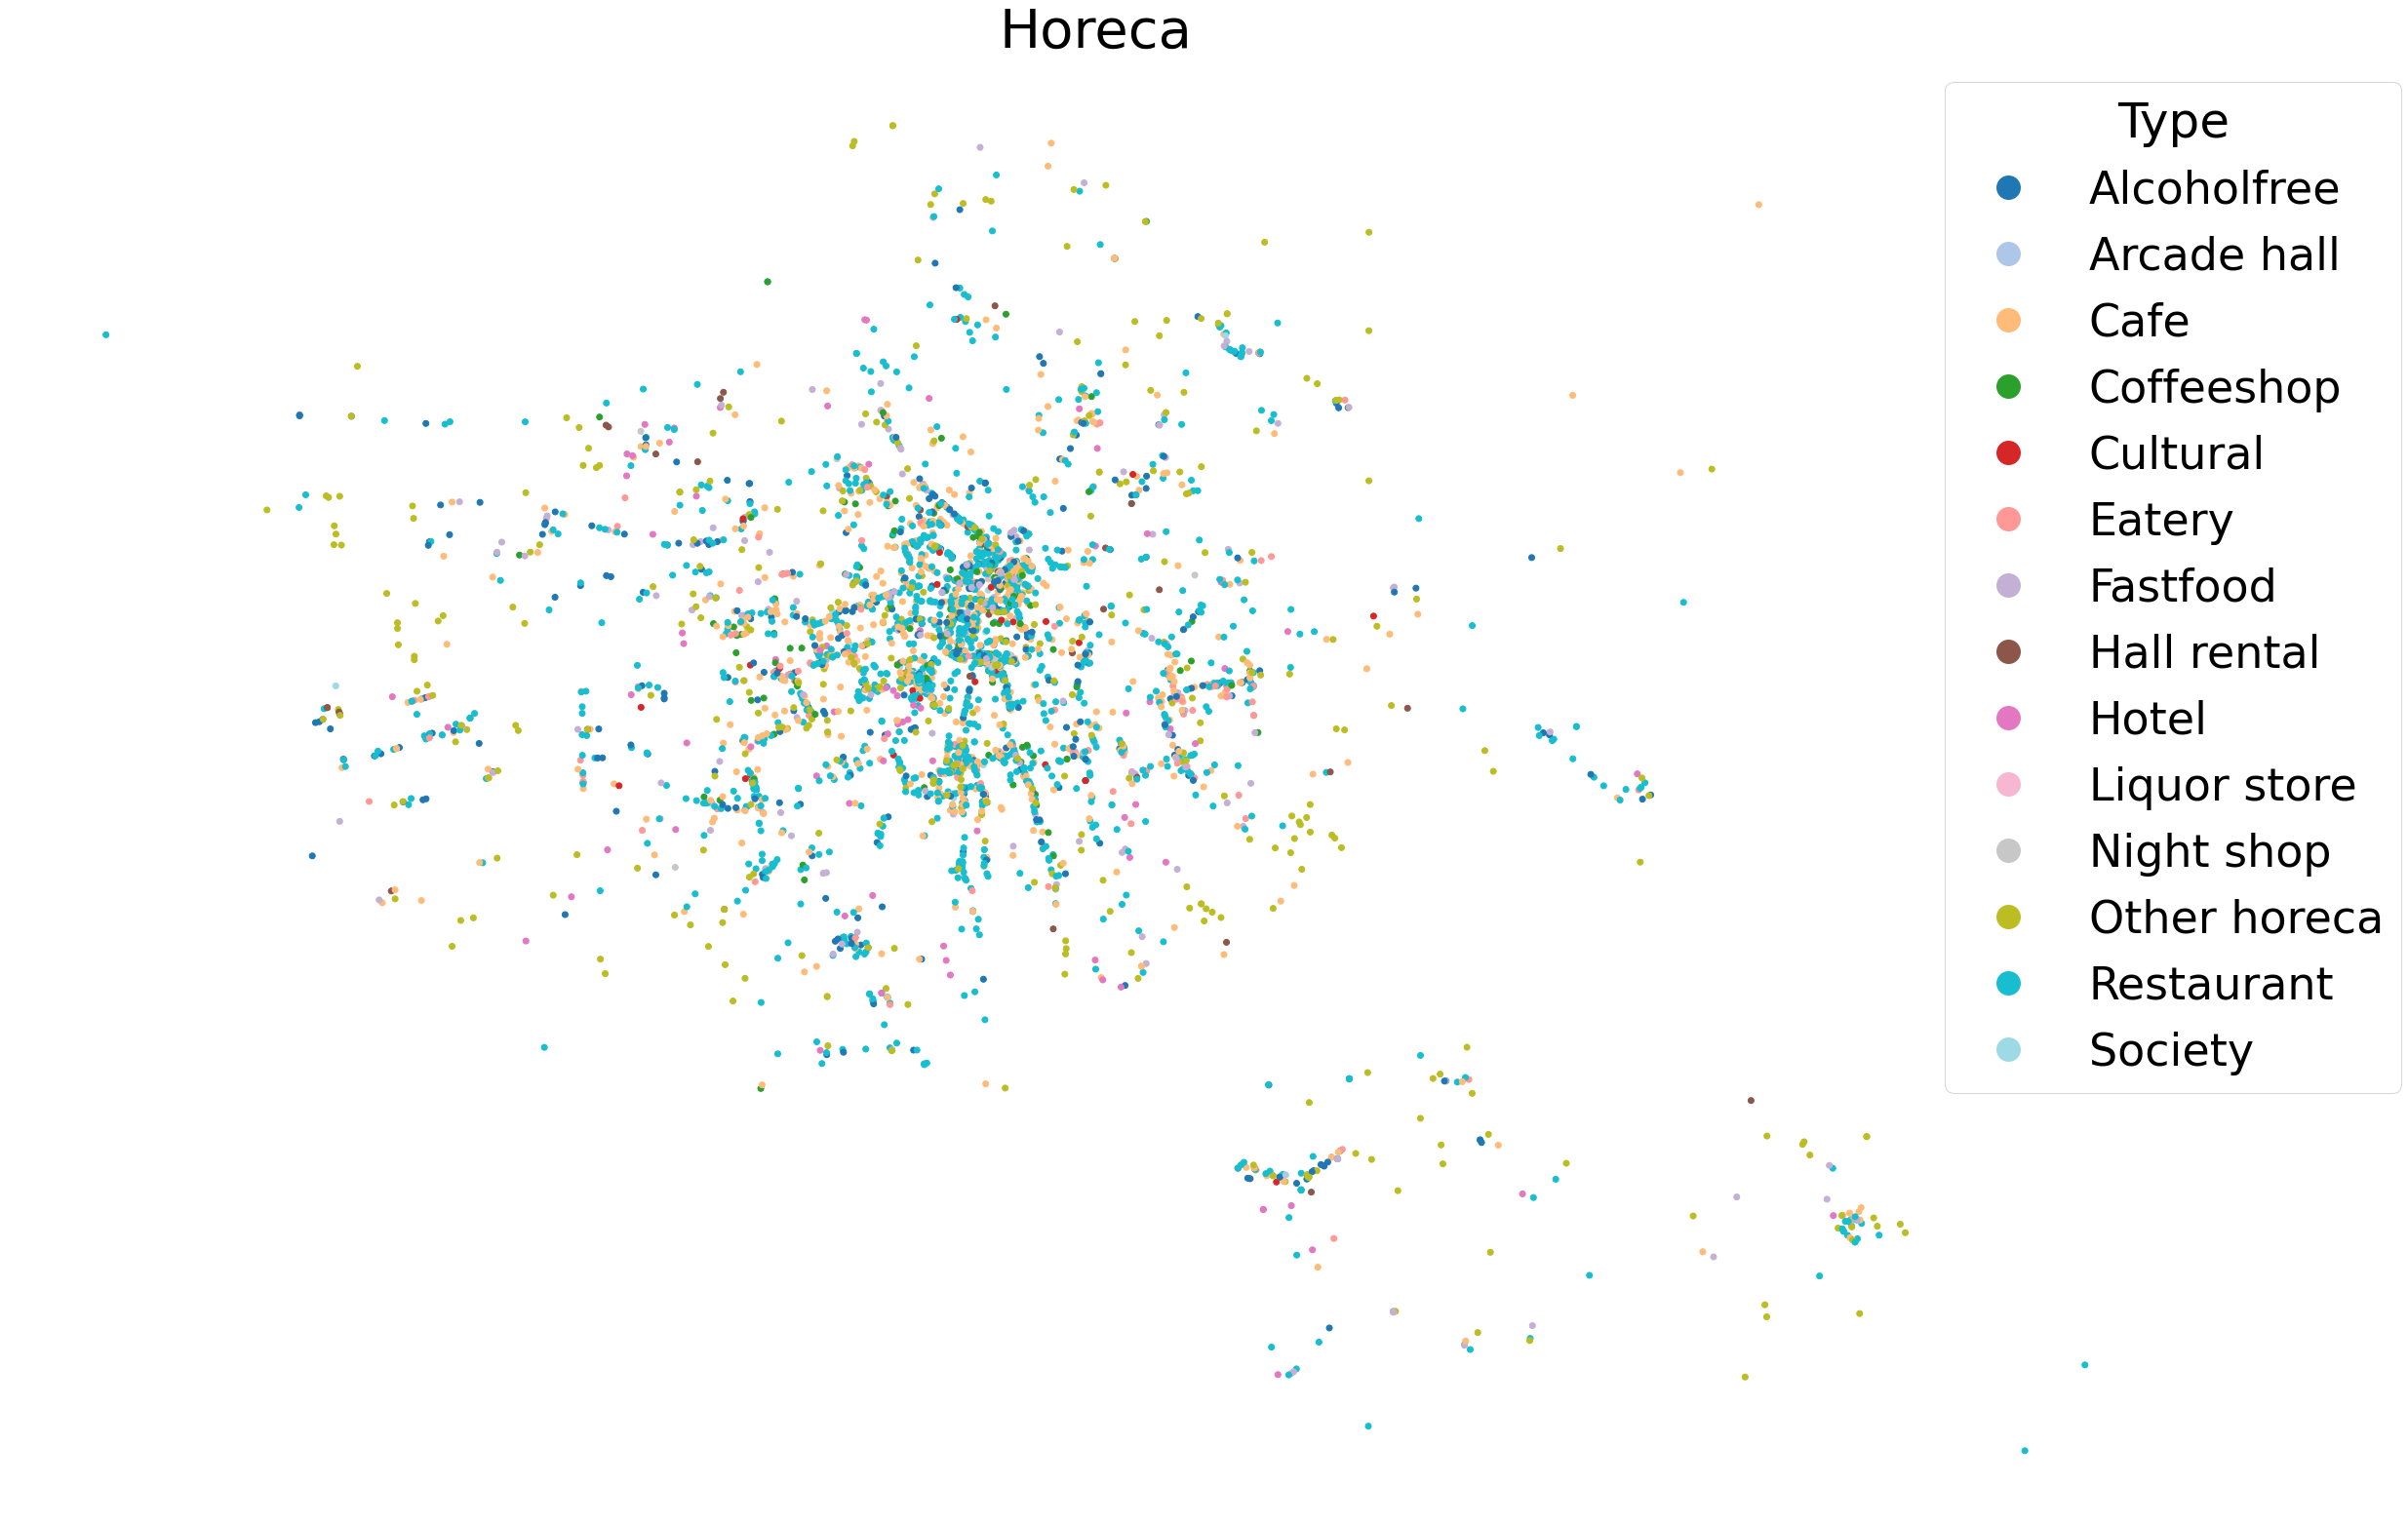

In [10]:
# Plot the functions
f, ax = plt.subplots(1, figsize=(40, 40))
ax.set_axis_off()
ax.set_title("Horeca", fontsize=56)
ax = horeca.plot(ax=ax, cmap='tab20', column = 'horeca_category', legend = True, legend_kwds={'loc':'upper left', 'bbox_to_anchor':(0.88,1), 'title_fontsize':50, 'title':'Type','markerscale': 2.5,'fontsize':46})
plt.show()

**Shopping areas**

In [15]:
print(shopping_areas.shape)
shopping_areas.head()

(132, 13)


id gebiedscode                      gebiedsnaam  code  oppervlakte  \
0   1          A2  Haarlemmerstraat/Haarlemmerdijk    A2         3.63   
1   2          A4               Nieuwendijk/Damrak  A4_1         7.93   
2   3          A6                  Dam/Magna Plaza  A6_1         3.91   
3   4          A6    Kalverstraat/Heiligeweg/Rokin  A6_2         7.90   
4   5          A7                  Utrechtsestraat  A7_1         1.33   

  winkelgebiedcode concentratiegebiedcode  \
0              001                     X4   
1              003                     X7   
2              004                     X9   
3              005                    X10   
4              006                    X11   

                concentratiegebiednaam wijk gebied categorie  \
0                Haarlemmerstraat/dijk  A05   DX01         K   
1                   Nieuwendijk/Damrak  A01   DX01         K   
2                   Dam/Magna Plaza eo  A01   DX01         K   
3  Kalverstraat/Heiligeweg/Rokin/Grimb  A01   DX01         K   
4                      Utrechtsestraat  A03   DX02         K   

      categorienaam                                           geometry  
0  Kernwinkelgebied  POLYGON ((4.89449 52.37920, 4.89295 52.38014, ...  
1  Kernwinkelgebied  POLYGON ((4.89834 52.37702, 4.89832 52.37713, ...  
2  Kernwinkelgebied  POLYGON ((4.89482 52.37293, 4.89476 52.37296, ...  
3  Kernwinkelgebied  POLYGON ((4.89380 52.37220, 4.89372 52.37221, ...  
4  Kernwinkelgebied  POLYGON ((4.89954 52.36109, 4.89935 52.36147, ...

In [16]:
shopping_areas.categorienaam.unique()

array(['Kernwinkelgebied', 'Buurtcentrum', 'Wijkcentrum klein',
       'Locatie voor perifere winkels', 'Trafficlocaties',
       'Stadsdeelcentra', 'Wijkcentrum groot'], dtype=object)

In [16]:
# Add new feature with translated functions
conditions = [
    (shopping_areas['categorienaam'] == 'Kernwinkelgebied'),
    (shopping_areas['categorienaam'] == 'Buurtcentrum'),
    (shopping_areas['categorienaam'] == 'Wijkcentrum klein'),
    (shopping_areas['categorienaam'] == 'Locatie voor perifere winkels'),
    (shopping_areas['categorienaam'] == 'Trafficlocaties'),
    (shopping_areas['categorienaam'] == 'Stadsdeelcentra'),
    (shopping_areas['categorienaam'] == 'Wijkcentrum groot')]
choices = ['Core shopping area', 'Neighborhood center', 'Quarter center small',
       'Location for peripheral shops', 'Traffic locations',
       'City district center', 'Quarter center large']
shopping_areas['shopping_area'] = np.select(conditions, choices, default='Other shopping')

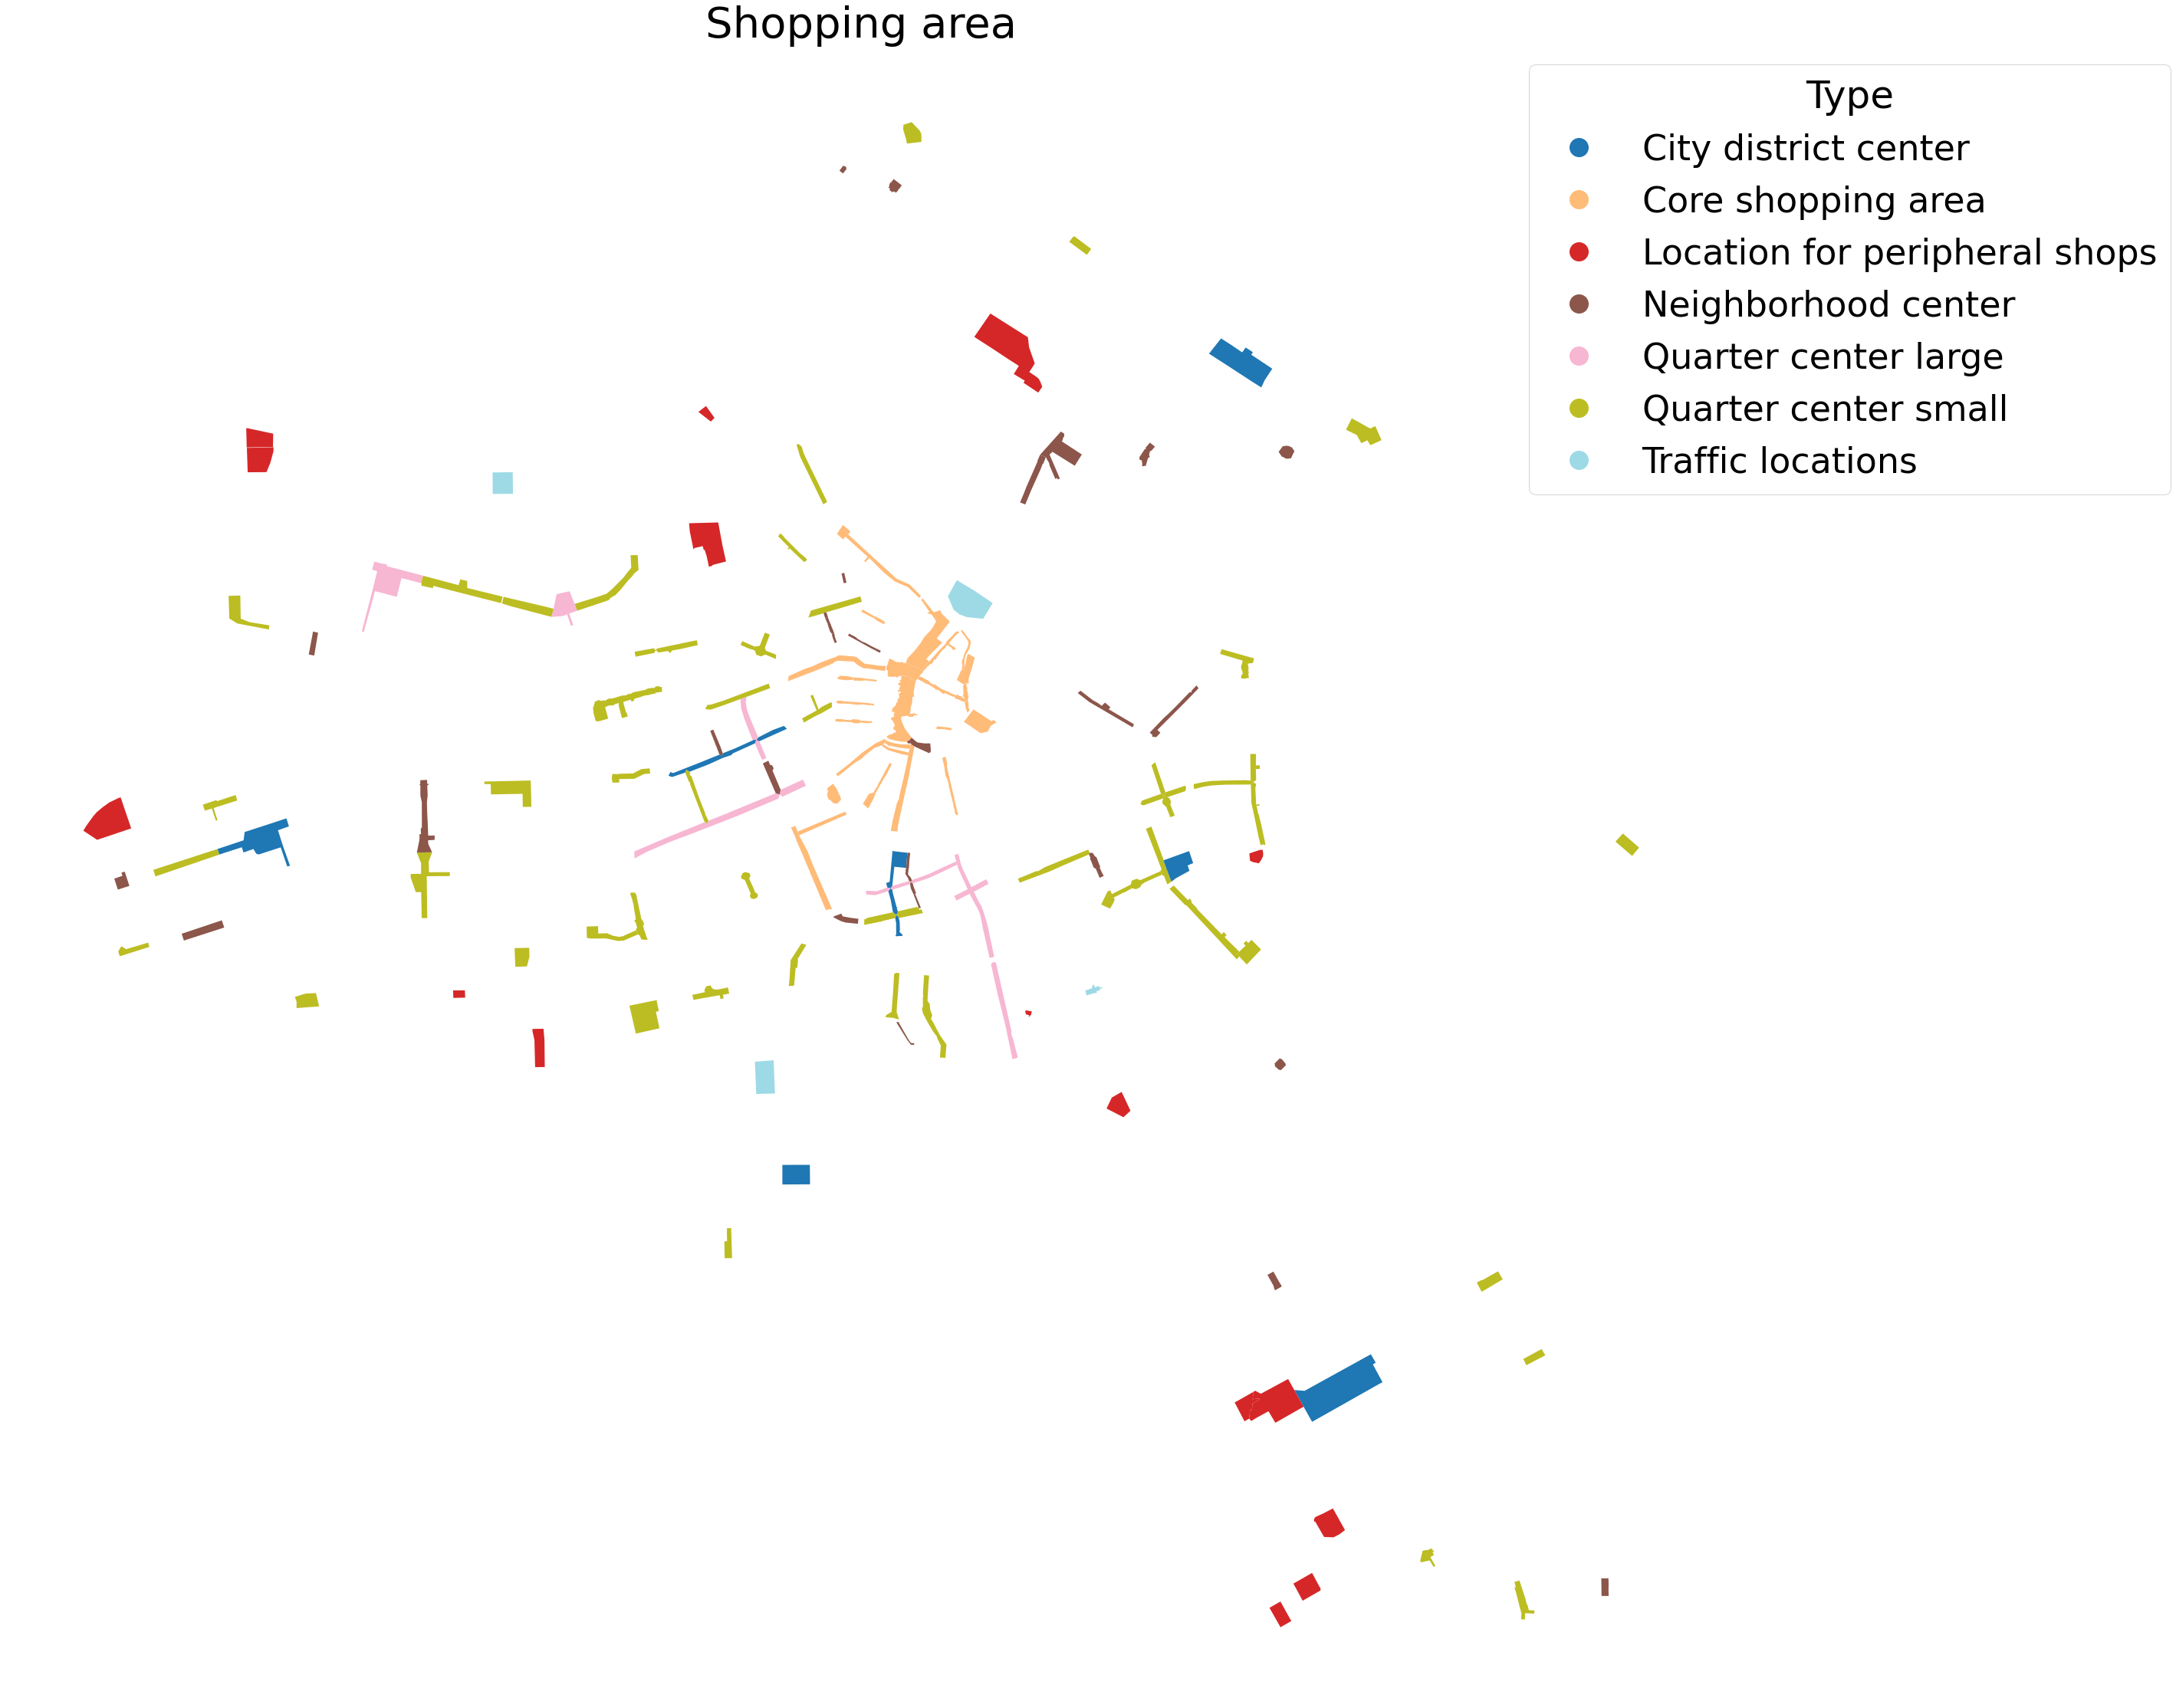

In [18]:
# Plot the shopping areas
f, ax = plt.subplots(1, figsize=(40, 40))
ax.set_axis_off()
ax.set_title("Shopping area", fontsize=56)
ax = shopping_areas.plot(ax=ax, cmap='tab20', column = 'shopping_area', legend = True, legend_kwds={'loc':'upper left', 'bbox_to_anchor':(0.88,1), 'title_fontsize':50, 'title':'Type','markerscale': 2.5,'fontsize':46})
plt.show()

**Function map (points of interest)**

In [19]:
print(function_map.shape)
function_map.head()

(32995, 13)


Functie  Functie_gecorrigeerd            VOT_ID  \
0                  kerk                     0  0363010010902423   
1               kantoor                     0  0363010012111639   
2  wijk- / buurtcentrum                     0  0363010000557297   
3  cafetaria / snackbar                     0  0363010000557315   
4  cafetaria / snackbar                     0  0363010000557316   

                 Adres  Aantal_adressen        Gebruiksdoel  \
0         Aakstraat 60                0  bijeenkomstfunctie   
1   Aalbersestraat 244                0      kantoorfunctie   
2  Aalbersestraat 248A                0  bijeenkomstfunctie   
3   Aalbersestraat 258                0  bijeenkomstfunctie   
4   Aalbersestraat 260                0  bijeenkomstfunctie   

            WOZ_gebruik         Hoofdfunctie Hoofdfunctie_ID  \
0                  kerk              Religie               R   
1               kantoor             Kantoren               K   
2  wijk- / buurtcentrum  Wijk / buurtcentrum               G   
3  cafetaria / snackbar               Horeca               H   
4  cafetaria / snackbar               Horeca               H   

   Gebruiksoppervlakte  Footprint  Oppervlakte_gecorrigeerd  \
0                    0          0                         0   
1                  239          0                         0   
2                  347          0                         0   
3                   76          0                         0   
4                    0          0                         0   

                   geometry  
0  POINT (4.91270 52.40758)  
1  POINT (4.79844 52.37938)  
2  POINT (4.79815 52.37995)  
3  POINT (4.79821 52.38082)  
4  POINT (4.79821 52.38087)

In [20]:
function_map.Hoofdfunctie.unique()

array(['Religie', 'Kantoren', 'Wijk / buurtcentrum', 'Horeca',
       'Detailhandel', 'Atelier / werkruimte', 'Onderwijs',
       'Onduidelijke functie', 'Opslag en distributie', 'Bedrijven',
       'Cultuur', 'Sport en recreatie', 'Zorg', 'Logies', 'Nuts',
       'Agrarisch bedrijf', '_Niet laten zien'], dtype=object)

In [17]:
# Add new feature with translated functions
conditions = [
    (function_map['Hoofdfunctie'] == 'Agrarisch bedrijf'),
    (function_map['Hoofdfunctie'] == 'Atelier / werkruimte'),
    (function_map['Hoofdfunctie'] == 'Bedrijven'),
    (function_map['Hoofdfunctie'] == 'Cultuur'),
    (function_map['Hoofdfunctie'] == 'Detailhandel'),
    (function_map['Hoofdfunctie'] == 'Horeca'),
    (function_map['Hoofdfunctie'] == 'Kantoren'),
    (function_map['Hoofdfunctie'] == 'Logies'),
    (function_map['Hoofdfunctie'] == 'Nuts'),
    (function_map['Hoofdfunctie'] == 'Onderwijs'),
    (function_map['Hoofdfunctie'] == 'Onduidelijke functie'),
    (function_map['Hoofdfunctie'] == 'Opslag en distributie'),
    (function_map['Hoofdfunctie'] == 'Religie'),
    (function_map['Hoofdfunctie'] == 'Sport en recreatie'),
    (function_map['Hoofdfunctie'] == 'Wijk / buurtcentrum'),
    (function_map['Hoofdfunctie'] == 'Zorg')]
choices = ['Agricultural','Atelier','Companies','Culture','Retail','Horeca','Offices','Lodging',
           'Public utility', 'Education','Unclear function','Storage','Religion','Sports','District center','Healthcare']
function_map['main_function'] = np.select(conditions, choices, default='Other function')

In [9]:
# Check count per function
function_map[['main_function','Gebruiksoppervlakte']].groupby('main_function').agg(['count','sum'])

Gebruiksoppervlakte         
                               count      sum
main_function                                
Agricultural                      71    89878
Atelier                         1185   349776
Companies                       2924  3295234
Culture                          472   629924
District center                  122    46934
Education                       1114  2202140
Healthcare                       804  1539125
Horeca                          3975   632156
Lodging                          716  1439113
Offices                         8053  7808283
Other function                     2    14508
Public utility                    96   213564
Religion                         220   133881
Retail                         10501  2370925
Sports                           637   528001
Storage                         1207  1808040
Unclear function                 896   809320

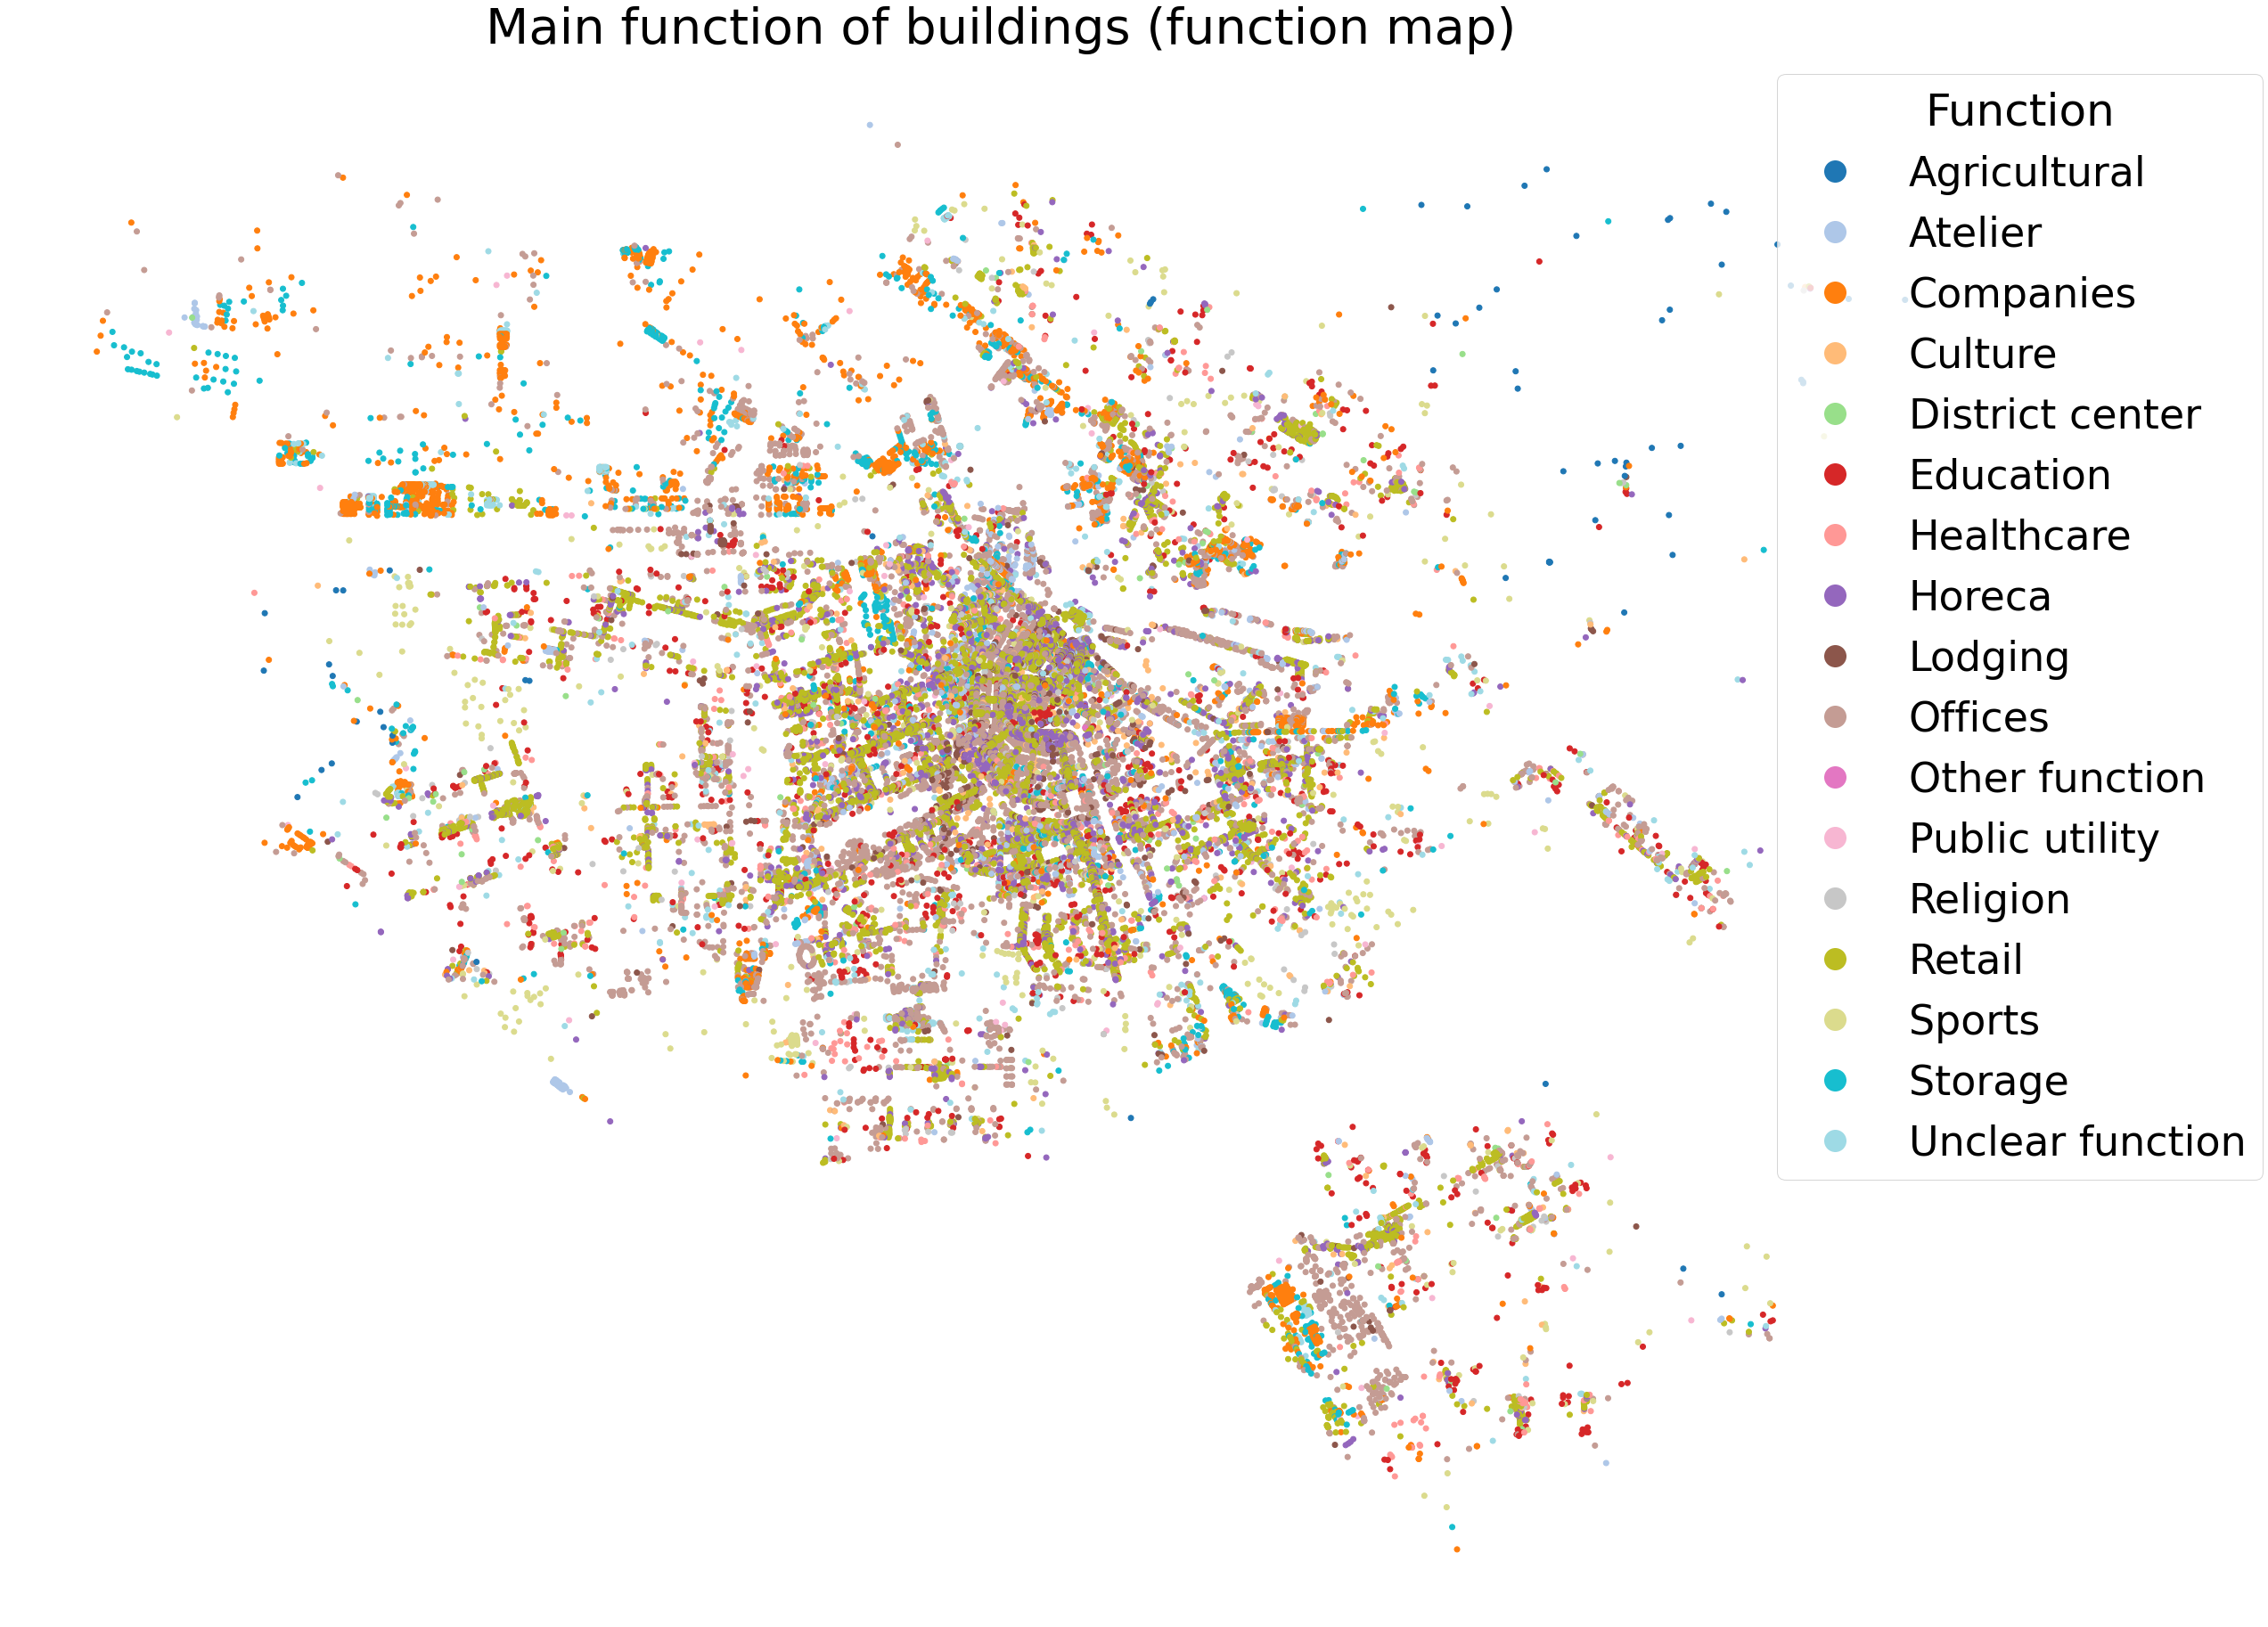

In [23]:
# Plot the functions
f, ax = plt.subplots(1, figsize=(40, 40))
ax.set_axis_off()
ax.set_title("Main function of buildings (function map)", fontsize=56)
ax = function_map.plot(ax=ax, cmap='tab20', column = 'main_function', legend = True, legend_kwds={'loc':'upper left', 'bbox_to_anchor':(0.88,1), 'title_fontsize':50, 'title':'Function','markerscale': 2.5,'fontsize':46})
plt.show()

**Function mix (land use)**

In [24]:
print(function_mix.shape)
function_mix.head()

(17963, 11)


LABEL BlokStraatCode   WON   VZN  WRK  \
0  Wonen 0% - Voorzieningen 100% - Werken 0%  AA01_00004981     0  8430    0   
1  Wonen 100% - Voorzieningen 0% - Werken 0%  AA02_00004738  1606     0    0   
2  Wonen 100% - Voorzieningen 0% - Werken 0%  AA02_00004944  1743     0    0   
3  Wonen 100% - Voorzieningen 0% - Werken 0%  AA02_00004945  1562     0    0   
4  Wonen 100% - Voorzieningen 0% - Werken 0%  AA02_00004981  3000     0    0   

   TOTAAL  WON_PERC  VZN_PERC  WRK_PERC  CAT  \
0    8430         0       100         0  VZN   
1    1606       100         0         0  WON   
2    1743       100         0         0  WON   
3    1562       100         0         0  WON   
4    3000       100         0         0  WON   

                                            geometry  
0  MULTIPOLYGON (((4.86911 52.39278, 4.86898 52.3...  
1  POLYGON ((4.87245 52.39270, 4.87245 52.39272, ...  
2  MULTIPOLYGON (((4.87219 52.39250, 4.87216 52.3...  
3  MULTIPOLYGON (((4.87107 52.39279, 4.87111 52.3...  
4  MULTIPOLYGON (((4.87098 52.39274, 4.87102 52.3...

In [25]:
function_mix.CAT.unique()

array(['VZN', 'WON', 'WON_VZN', 'WRK', 'WON_WRK', 'GEMENGD', 'VZN_WRK'],
      dtype=object)

In [18]:
# Add feature with the main land use
conditions = [
(function_mix['WON_PERC'] > function_mix['VZN_PERC']) & (function_mix['WON_PERC'] > function_mix['WRK_PERC']),
(function_mix['WRK_PERC'] > function_mix['VZN_PERC']) & (function_mix['WRK_PERC'] > function_mix['WON_PERC']),
(function_mix['VZN_PERC'] > function_mix['WON_PERC']) & (function_mix['VZN_PERC'] > function_mix['WRK_PERC'])]
choices = ['Homes','Work','Services']
function_mix['function_category'] = np.select(conditions, choices, default='Mixed')

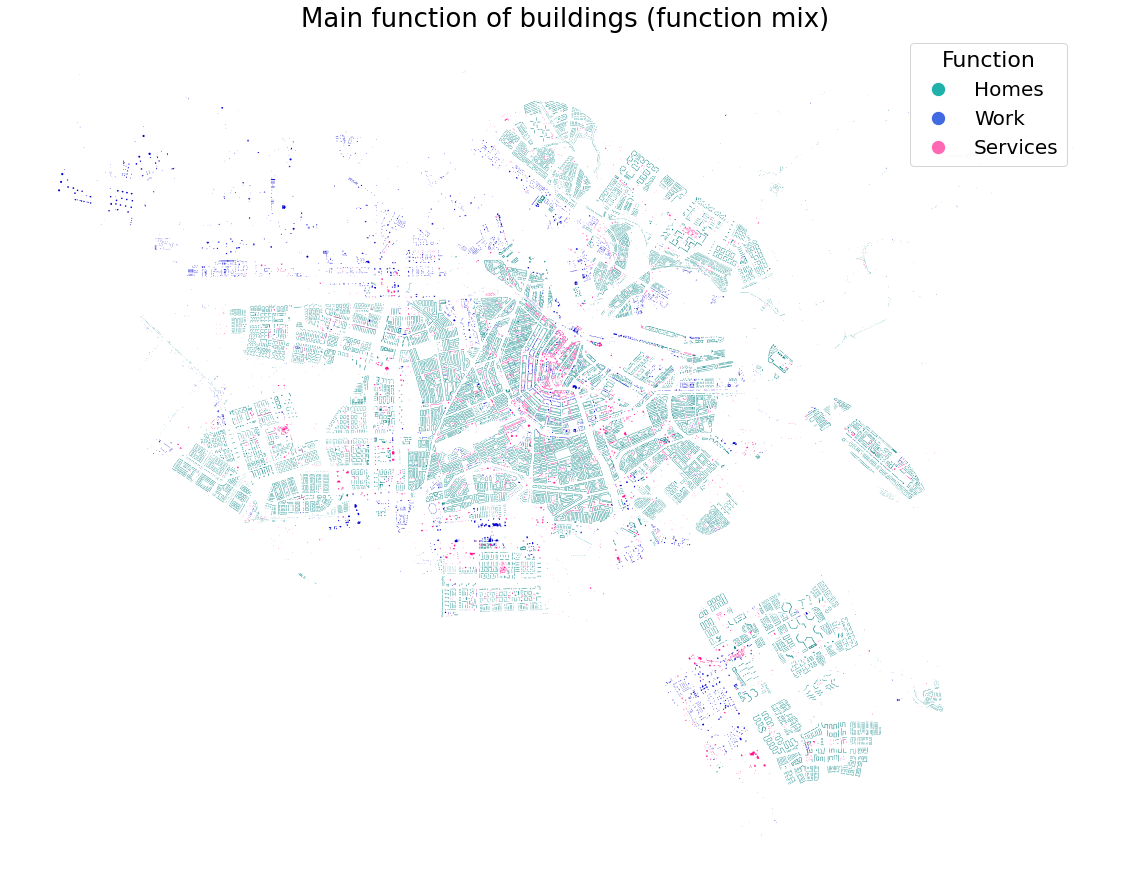

In [27]:
# Plot the main land use per building (segment)
colorPalette = {'Homes': 'teal',
               'Work': 'mediumblue',
               'Services': 'deeppink',
               'Mixed' : 'lightgrey'}

# Plot data
fig, ax = plt.subplots(figsize=(20, 20))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in function_mix.groupby('function_category'):

    # Define the color for each group using the dictionary
    color = colorPalette[ctype]

    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,)
             #edgecolor="white")

ax.set_title("Main function of buildings (function mix)", fontsize=26)
ax.set_axis_off()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Homes',
                          markerfacecolor='lightseagreen', markersize=12),
                  Line2D([0], [0], marker='o', color='w', label='Work',
                          markerfacecolor='royalblue', markersize=12),
                  Line2D([0], [0], marker='o', color='w', label='Services',
                          markerfacecolor='hotpink', markersize=12)]

ax.legend(handles=legend_elements, title='Function',prop={'size': 20}, title_fontsize=22,loc = 'upper left', bbox_to_anchor = (0.8,1), markerscale=1.2)
plt.show()

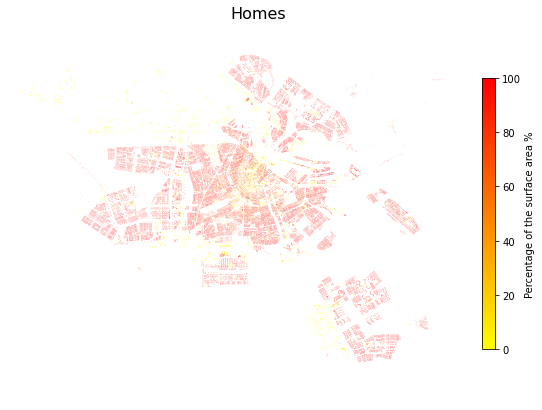

In [28]:
# Plot the percentage of surface area for the land use 'Homes' per building (segement)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_axis_off()
cmap = cm.autumn
cmap_reversed = cmap.reversed()
ax.set_title("Homes", fontsize=16)
ax = function_mix.plot(ax=ax, column = 'WON_PERC', cmap=cmap_reversed, legend = True, legend_kwds={'label': 'Percentage of the surface area %','shrink': 0.5, 'pad':-0.05})#markersize='Gebruiksoppervlakte')
plt.show()

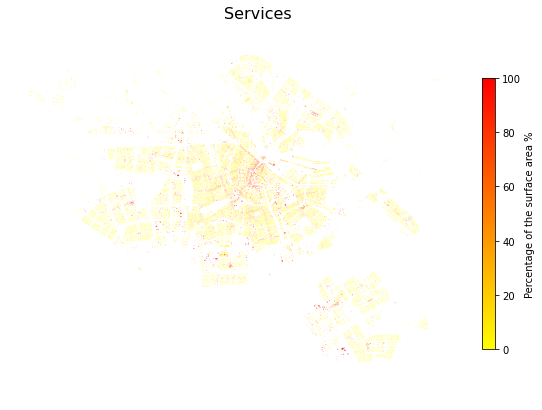

In [29]:
# Plot the percentage of surface area for the land use 'Services' per building (segement)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_axis_off()
ax.set_title("Services", fontsize=16)
ax = function_mix.plot(ax=ax, column = 'VZN_PERC', cmap=cmap_reversed, legend = True, legend_kwds={'label': 'Percentage of the surface area %','shrink': 0.5, 'pad':-0.05})#markersize='Gebruiksoppervlakte')
plt.show()

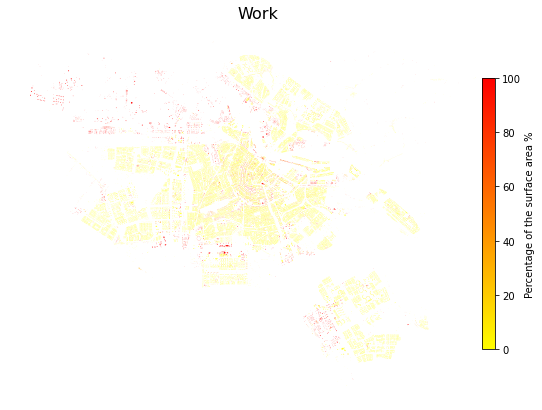

In [30]:
# Plot the percentage of surface area for the land use 'Work' per building (segement)
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_axis_off()
ax.set_title("Work", fontsize=16)
ax = function_mix.plot(ax=ax, column = 'WRK_PERC', cmap=cmap_reversed, legend = True, legend_kwds={'label': 'Percentage of the surface area %','shrink': 0.5, 'pad':-0.05})#markersize='Gebruiksoppervlakte')
plt.show()

**Public transport (tram and metro stations)**

In [7]:
tram_metro.head()

Naam Modaliteit              Lijn  Lijn_select  \
0               Nieuwezijds Kolk       Tram  2 | 12 | 13 | 17  02|12|13|17   
1  Surinameplein / Curaçaostraat       Tram            1 | 17        01|17   
2             Johan Huizingalaan       Tram            1 | 17        01|17   
3                  Prinsengracht       Tram            2 | 12        02|12   
4                   Keizergracht       Tram            2 | 12        02|12   

   RADIUS                                   Label                  geometry  
0       5     2 | 12 | 13 | 17 - Nieuwezijds Kolk  POINT (4.89334 52.37607)  
1       5  1 | 17 - Surinameplein / Curaçaostraat  POINT (4.85312 52.35838)  
2       5             1 | 17 - Johan Huizingalaan  POINT (4.82733 52.35782)  
3       5                  2 | 12 - Prinsengracht  POINT (4.88447 52.36502)  
4       5                   2 | 12 - Keizergracht  POINT (4.88645 52.36596)

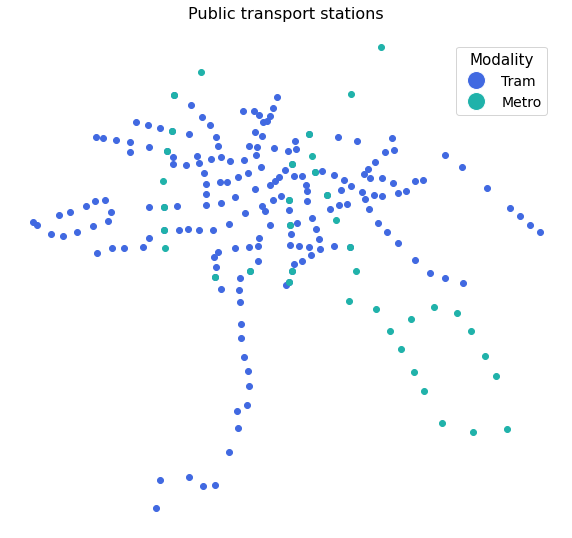

In [42]:
# Plot the different public transport stations
colorPalette = {'Tram': 'royalblue',
               'Metro' : 'lightseagreen'} #hotpink lightseagreen

# Plot data
fig, ax = plt.subplots(figsize=(10, 10))
ax = vehicle_parking.loc[vehicle_parking.year == 2018].plot(ax=ax, color = 'lightgrey')

# Loop through each attribute type and plot it using the colors assigned in the dictionary
modalities = ['Tram','Metro']
for mode in modalities:

    # Define the color for each group using the dictionary
    color = colorPalette[mode]

    # Plot each group using the color defined above
    tram_metro.to_crs({'init': 'epsg:3857'}).loc[tram_metro.Modaliteit == mode].plot(color=color,
              ax=ax,
              label=mode)

# ax.set(title='Parked vehicles per 100m2 sidewalk in the 2021 dataset')
ax.set_title("Public transport stations", fontsize=16)
ax.set_axis_off()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Tram',
                          markerfacecolor='royalblue', markersize=12),
                  Line2D([0], [0], marker='o', color='w', label='Metro',
                          markerfacecolor='lightseagreen', markersize=12)]

ax.legend(handles=legend_elements, title='Modality',prop={'size': 14}, title_fontsize=15,loc = 'upper right',bbox_to_anchor = (0.98,0.97), markerscale = 1.5)
plt.show()

### **4 Merge the neighborhood data with the parking data**

**Merge public transport data**

In [21]:
vehicle_parking_OV = gpd.sjoin_nearest(vehicle_parking.to_crs({'init': 'epsg:32631'}), tram_metro[['geometry','Modaliteit']].to_crs({'init': 'epsg:32631'}), how='left', max_distance=100, distance_col="dist_OV")
print(str(vehicle_parking_OV.shape))
vehicle_parking_OV_pivot = pd.pivot_table(vehicle_parking_OV[['year','section_2018','Modaliteit']], index=['section_2018','year'], columns=['Modaliteit'], aggfunc=len, fill_value=0).reset_index().rename_axis(None, axis=1)
vehicle_parking_OV_pivot.head()

(98788, 239)


section_2018  year  Metro  Tram
0         10258  2019      0     1
1         10258  2020      0     1
2         10258  2021      0     1
3         10262  2019      0     1
4         10262  2020      0     1

In [22]:
vehicle_parking = pd.merge(vehicle_parking, vehicle_parking_OV_pivot, how = 'left', on= ['section_2018','year'])
vehicle_parking.Metro.fillna(0, inplace =  True)
vehicle_parking.Tram.fillna(0, inplace =  True)
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((547095.956 6864733.318, 547095.956 6...   
1         12744  POLYGON ((549759.863 6863099.700, 549756.777 6...   
2         21603  POLYGON ((542946.247 6862171.722, 542942.347 6...   
3         34596  POLYGON ((537799.402 6868643.750, 537796.160 6...   
4         15807  POLYGON ((544434.867 6862393.999, 544434.867 6...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

In [24]:
# Add feature with the public transport type
conditions = [
    (vehicle_parking['Metro'] == 0) & (vehicle_parking['Tram'] == 0),
    (vehicle_parking['Metro'] > 0) & (vehicle_parking['Tram'] == 0),
    (vehicle_parking['Metro'] == 0) & (vehicle_parking['Tram'] > 0),
    (vehicle_parking['Metro'] > 0) & (vehicle_parking['Tram'] > 0)]
choices = ['None','Metro','Tram','Both']
vehicle_parking['public_transport'] = np.select(conditions, choices, default='?')

# Add binary features
for cat in ['Tram','Metro']:
    conditions = [
        (vehicle_parking[cat] == 0),
        (vehicle_parking[cat] > 0)]
    choices = [0 , 1]
    vehicle_parking[cat + '_binary'] = np.select(conditions, choices, default='?')

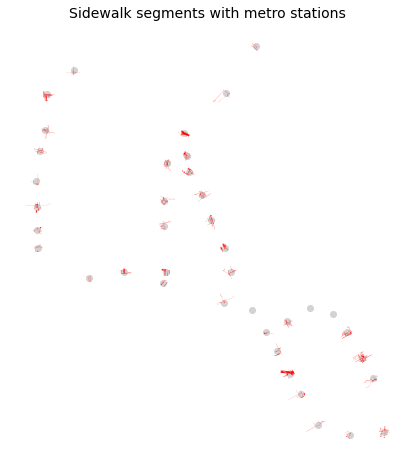

In [24]:
# Check the merged data for metro stations
f, ax = plt.subplots(1, figsize=(8, 8))
ax.set_axis_off()
ax.set_title("Sidewalk segments with metro stations", fontsize=14)
ax = tram_metro.to_crs({'init': 'epsg:3857'}).loc[tram_metro.Modaliteit == 'Metro'].plot(color='lightgrey',ax=ax)
ax = vehicle_parking.loc[(vehicle_parking.Metro >= 1) & (vehicle_parking.year == 2021)].plot(ax=ax, color = 'red')
plt.show()

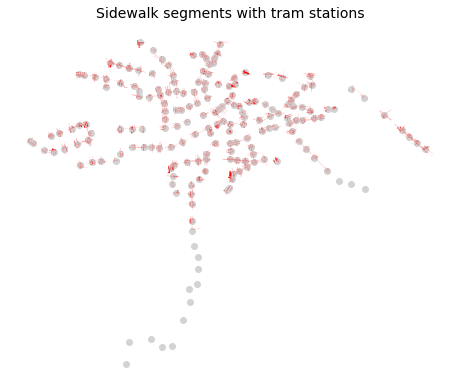

In [30]:
# Check the merged data for tram stations
f, ax = plt.subplots(1, figsize=(8, 8))
ax.set_axis_off()
ax.set_title("Sidewalk segments with tram stations", fontsize=14)
ax = tram_metro.to_crs({'init': 'epsg:3857'}).loc[tram_metro.Modaliteit == 'Tram'].plot(color='lightgrey',ax=ax)
ax = vehicle_parking.loc[(vehicle_parking.Tram >= 1) & (vehicle_parking.year == 2021)].plot(ax=ax, color = 'red')
plt.show()

**Merge function map (points of interest) data**

In [25]:
vehicle_parking_function_map = gpd.sjoin_nearest(vehicle_parking.to_crs({'init': 'epsg:32631'}), function_map[['geometry','main_function','Gebruiksoppervlakte']].to_crs({'init': 'epsg:32631'}), how='right', max_distance=100, distance_col="dist_functionmap")
print(str(vehicle_parking_function_map.shape))
# vehicle_parking_2021_functionmap_pivot = pd.pivot_table(vehicle_parking_2021_functionmap[['section_2018','main_function','Gebruiksoppervlakte']], index='section_2018', columns='main_function', values = 'Gebruiksoppervlakte', aggfunc=sum, fill_value=0).reset_index().rename_axis(None, axis=1)
vehicle_parking_function_map_pivot = pd.pivot_table(vehicle_parking_function_map[['year','section_2018','main_function','Gebruiksoppervlakte']], index=['section_2018','year'], columns='main_function', values = 'Gebruiksoppervlakte', aggfunc=len, fill_value=0).reset_index().rename_axis(None, axis=1)
vehicle_parking_function_map_pivot.head()

(95819, 245)


section_2018    year  Agricultural  Atelier  Companies  Culture  \
0       10001.0  2019.0             0        0          0        0   
1       10001.0  2020.0             0        0          0        0   
2       10001.0  2021.0             0        0          0        0   
3       10006.0  2019.0             0        0          0        0   
4       10006.0  2020.0             0        0          0        0   

   District center  Education  Healthcare  Horeca  Lodging  Offices  \
0                0          0           0       0        0        0   
1                0          0           0       0        0        0   
2                0          0           0       0        0        0   
3                0          0           0       0        0        0   
4                0          0           0       0        0        0   

   Other function  Public utility  Religion  Retail  Sports  Storage  \
0               0               0         0       0       0        1   
1               0               0         0       0       0        1   
2               0               0         0       0       0        1   
3               0               1         0       0       0        0   
4               0               1         0       0       0        0   

   Unclear function  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [26]:
vehicle_parking = pd.merge(vehicle_parking, vehicle_parking_function_map_pivot, how = 'left', on= ['section_2018', 'year'])
vehicle_parking[function_map.main_function.unique().tolist()] = vehicle_parking[function_map.main_function.unique().tolist()].fillna(0)
print(vehicle_parking.shape)
vehicle_parking.head()

(97998, 258)


section_2018                                           geometry  \
0         13793  POLYGON ((547095.956 6864733.318, 547095.956 6...   
1         12744  POLYGON ((549759.863 6863099.700, 549756.777 6...   
2         21603  POLYGON ((542946.247 6862171.722, 542942.347 6...   
3         34596  POLYGON ((537799.402 6868643.750, 537796.160 6...   
4         15807  POLYGON ((544434.867 6862393.999, 544434.867 6...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

In [27]:
# Add feature that indicate the main function
vehicle_parking['main_function'] = vehicle_parking[function_map.main_function.unique()].idxmax(axis=1)

# Add amount per 100m2 sidewalk
cat_columns = function_map.main_function.unique()
for cat in cat_columns:    
    vehicle_parking[cat + '_per_100m2'] = vehicle_parking[cat] / vehicle_parking['area'] * 100

    # Add binary features
for cat in cat_columns:
    conditions = [
        (vehicle_parking[cat] == 0),
        (vehicle_parking[cat] > 0)]
    choices = [0 , 1]
    vehicle_parking[cat + '_binary'] = np.select(conditions, choices, default='?')

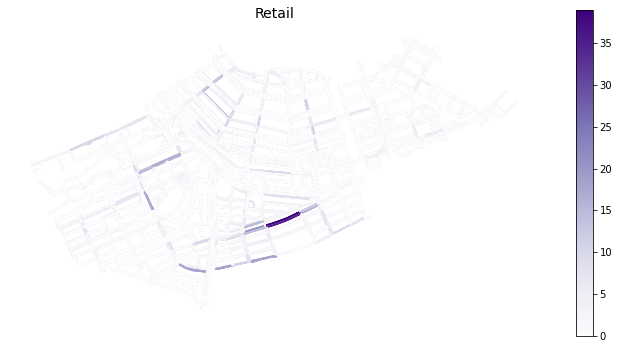

In [49]:
quarters = ['Oude Pijp',
'Museumkwartier',
'Vondelbuurt',
'De Weteringschans',
'Weesperbuurt/Plantage',
'Grachtengordel-Zuid']

f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_axis_off()
feature = 'Retail'
ax.set_title(feature, fontsize=14)
base =   vehicle_parking.set_geometry('geometry_line').loc[(vehicle_parking.quarter_name_quarters.isin(quarters)) & (vehicle_parking.year ==2021)].plot(ax=ax, color = 'lightgrey')
ax =  vehicle_parking.set_geometry('geometry_line').loc[(vehicle_parking[feature] < 50) & (vehicle_parking[feature] >= 0) & (vehicle_parking.quarter_name_quarters.isin(quarters))& (vehicle_parking.year ==2021)].plot(ax=base, cmap='Purples',column = feature, legend = True)
plt.show() 

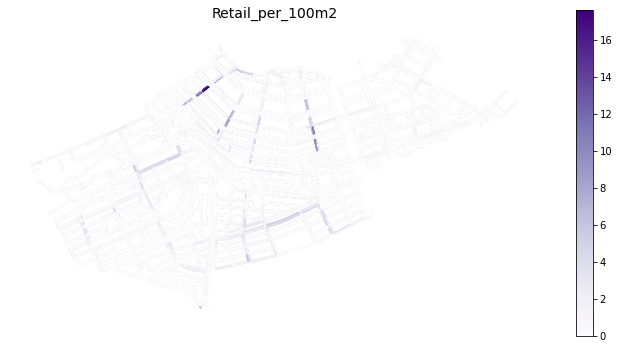

In [53]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_axis_off()
feature = 'Retail_per_100m2'
ax.set_title(feature, fontsize=14)
base =   vehicle_parking.set_geometry('geometry_line').loc[vehicle_parking.quarter_name.isin(quarters)].plot(ax=ax, color = 'lightgrey')
ax =  vehicle_parking.set_geometry('geometry_line').loc[(vehicle_parking[feature] < 50) & (vehicle_parking[feature] >= 0) & (vehicle_parking.quarter_name.isin(quarters))].plot(ax=base, cmap='Purples',column = feature, legend = True)
plt.show() 

**Merge with Horeca data**

In [28]:
vehicle_parking_horeca = gpd.sjoin_nearest(vehicle_parking.to_crs({'init': 'epsg:32631'}), horeca[['geometry','horeca_category']].to_crs({'init': 'epsg:32631'}), how='right', max_distance=100, distance_col="dist_horeca")
print(str(vehicle_parking_horeca.shape))
vehicle_parking_horeca_pivot = pd.pivot_table(vehicle_parking_horeca[['year','section_2018','horeca_category']], index=['section_2018','year'], columns='horeca_category', values = 'horeca_category', aggfunc=len, fill_value=0).reset_index().rename_axis(None, axis=1)
vehicle_parking_horeca_pivot.head()

(12072, 296)


section_2018    year  Alcoholfree  Arcade hall  Cafe  Coffeeshop  Cultural  \
0       10035.0  2019.0            0            0     1           0         0   
1       10035.0  2020.0            0            0     1           0         0   
2       10035.0  2021.0            0            0     1           0         0   
3       10106.0  2019.0            0            0     0           0         0   
4       10106.0  2020.0            0            0     0           0         0   

   Eatery  Fastfood  Hall rental  Hotel  Liquor store  Night shop  \
0       0         0            0      0             0           0   
1       0         0            0      0             0           0   
2       0         0            0      0             0           0   
3       0         0            1      0             0           0   
4       0         0            1      0             0           0   

   Other horeca  Restaurant  Society  
0             0           0        0  
1             0           0        0  
2             0           0        0  
3             0           0        0  
4             0           0        0

In [31]:
horeca_cols = horeca.horeca_category.unique()
vehicle_parking = pd.merge(vehicle_parking, vehicle_parking_horeca_pivot, how = 'left', on=['section_2018','year'])
vehicle_parking[horeca_cols] = vehicle_parking[horeca_cols].fillna(0)
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((547095.956 6864733.318, 547095.956 6...   
1         12744  POLYGON ((549759.863 6863099.700, 549756.777 6...   
2         21603  POLYGON ((542946.247 6862171.722, 542942.347 6...   
3         34596  POLYGON ((537799.402 6868643.750, 537796.160 6...   
4         15807  POLYGON ((544434.867 6862393.999, 544434.867 6...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

In [32]:
# Add feature that indicates the main function
vehicle_parking['main_horeca'] = vehicle_parking[horeca_cols].idxmax(axis=1)

# Add amount per 100m2 sidewalk
for cat in horeca_cols:    
    vehicle_parking[cat + '_per_100m2'] = vehicle_parking[cat] / vehicle_parking['area'] * 100

# Add binary features
for cat in horeca_cols:
    conditions = [
        (vehicle_parking[cat] == 0),
        (vehicle_parking[cat] > 0)]
    choices = [0 , 1]
    vehicle_parking[cat + '_binary'] = np.select(conditions, choices, default='?')

In [33]:
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((547095.956 6864733.318, 547095.956 6...   
1         12744  POLYGON ((549759.863 6863099.700, 549756.777 6...   
2         21603  POLYGON ((542946.247 6862171.722, 542942.347 6...   
3         34596  POLYGON ((537799.402 6868643.750, 537796.160 6...   
4         15807  POLYGON ((544434.867 6862393.999, 544434.867 6...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

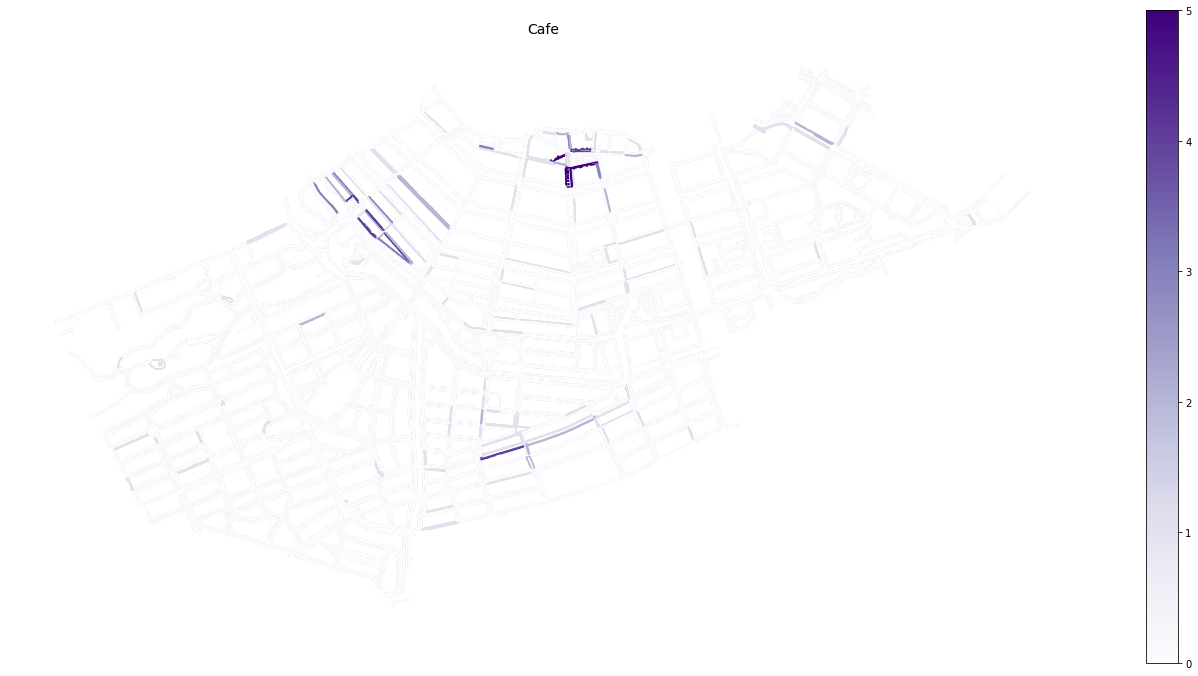

In [57]:
quarters = ['Oude Pijp',
'Museumkwartier',
'Vondelbuurt',
'De Weteringschans',
'Weesperbuurt/Plantage',
'Grachtengordel-Zuid']

f, ax = plt.subplots(1, figsize=(24, 12))
ax.set_axis_off()
feature = 'Cafe'
ax.set_title(feature, fontsize=14)
base =   vehicle_parking.set_geometry('geometry_line').loc[vehicle_parking.quarter_name.isin(quarters)].plot(ax=ax, color = 'lightgrey')
ax =  vehicle_parking.set_geometry('geometry_line').loc[(vehicle_parking[feature] < 50) & (vehicle_parking[feature] >= 0) & (vehicle_parking.quarter_name.isin(quarters))].plot(ax=base, cmap='Purples',column = feature, legend = True)
plt.show() 

**Merge with shopping area data**

In [36]:
# Within shopping area
vehicle_parking_shopping_areas_within = gpd.sjoin(vehicle_parking.to_crs({'init': 'epsg:32631'}), shopping_areas[['shopping_area', 'geometry']].to_crs({'init': 'epsg:32631'}), predicate = 'within', how='left')
vehicle_parking_shopping_areas_within.rename(columns = {'shopping_area':'shopping_area_within'}, inplace = True)
vehicle_parking = vehicle_parking_shopping_areas_within.drop_duplicates(subset=['section_2018','year'], keep='first')
vehicle_parking.drop(['index_right'], axis=1, inplace=True)
vehicle_parking['shopping_area_within'] = vehicle_parking['shopping_area_within'].fillna('None')
vehicle_parking['is_shopping_area_within'] = np.where(vehicle_parking['shopping_area_within']=='None', 0, 1)
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((630390.484 5802348.362, 630390.491 5...   
1         12744  POLYGON ((632046.733 5801394.876, 632044.880 5...   
2         21603  POLYGON ((627892.631 5800718.547, 627890.284 5...   
3         34596  POLYGON ((624643.263 5804586.620, 624641.268 5...   
4         15807  POLYGON ((628799.981 5800877.938, 628799.989 5...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

In [37]:
# Intersects shopping area
vehicle_parking_shopping_areas_intersects = gpd.sjoin(vehicle_parking.to_crs({'init': 'epsg:32631'}), shopping_areas[['shopping_area', 'geometry']].to_crs({'init': 'epsg:32631'}), predicate = 'intersects', how='left')
vehicle_parking_shopping_areas_intersects.rename(columns = {'shopping_area':'shopping_area_intersects'}, inplace = True)
vehicle_parking = vehicle_parking_shopping_areas_intersects.drop_duplicates(subset=['section_2018','year'], keep='first')
vehicle_parking.drop(['index_right'], axis=1, inplace=True)
vehicle_parking['shopping_area_intersects'] = vehicle_parking['shopping_area_intersects'].fillna('None')
vehicle_parking['is_shopping_area_intersects'] = np.where(vehicle_parking['shopping_area_intersects']=='None', 0, 1)
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((630390.484 5802348.362, 630390.491 5...   
1         12744  POLYGON ((632046.733 5801394.876, 632044.880 5...   
2         21603  POLYGON ((627892.631 5800718.547, 627890.284 5...   
3         34596  POLYGON ((624643.263 5804586.620, 624641.268 5...   
4         15807  POLYGON ((628799.981 5800877.938, 628799.989 5...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

In [38]:
# One-hot encode shopping area feature(s)
vehicle_parking = pd.concat([vehicle_parking, pd.get_dummies(vehicle_parking.shopping_area_within, prefix = 'Within', prefix_sep = ' ')], axis=1)
vehicle_parking.drop(['Within None'], axis=1, inplace=True)
vehicle_parking = pd.concat([vehicle_parking, pd.get_dummies(vehicle_parking.shopping_area_intersects, prefix = 'Intersects', prefix_sep = ' ')], axis=1)
vehicle_parking.drop(['Intersects None'], axis=1, inplace=True)
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((630390.484 5802348.362, 630390.491 5...   
1         12744  POLYGON ((632046.733 5801394.876, 632044.880 5...   
2         21603  POLYGON ((627892.631 5800718.547, 627890.284 5...   
3         34596  POLYGON ((624643.263 5804586.620, 624641.268 5...   
4         15807  POLYGON ((628799.981 5800877.938, 628799.989 5...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

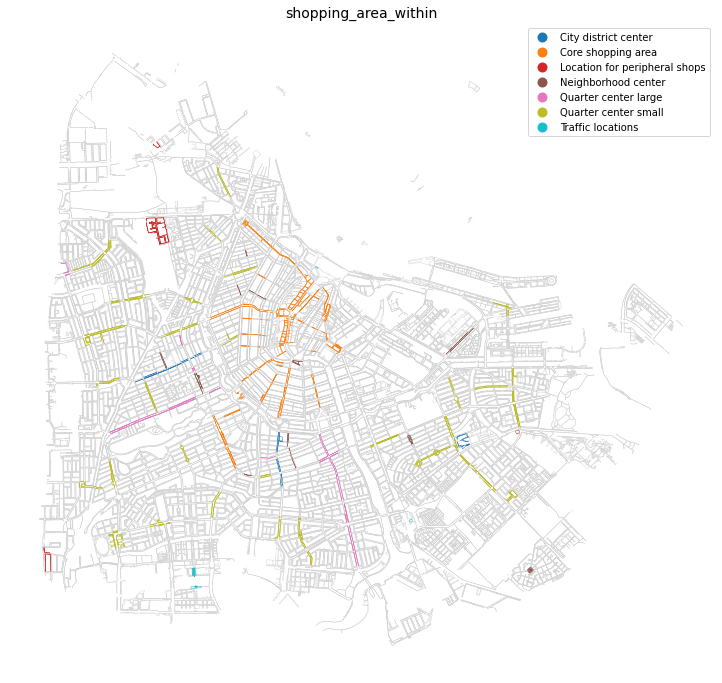

In [64]:
# street segments within shopping areas
f, ax = plt.subplots(1, figsize=(24, 12))
ax.set_axis_off()
feature = 'shopping_area_within'
ax.set_title(feature, fontsize=14)
base = vehicle_parking.set_geometry('geometry_line').plot(linewidth = 0.4, ax=ax, color = 'lightgrey')
ax = vehicle_parking.set_geometry('geometry_line').loc[vehicle_parking[feature] != 'None'].plot(linewidth = 0.4, ax=base, column = feature, legend = True)
plt.show() 

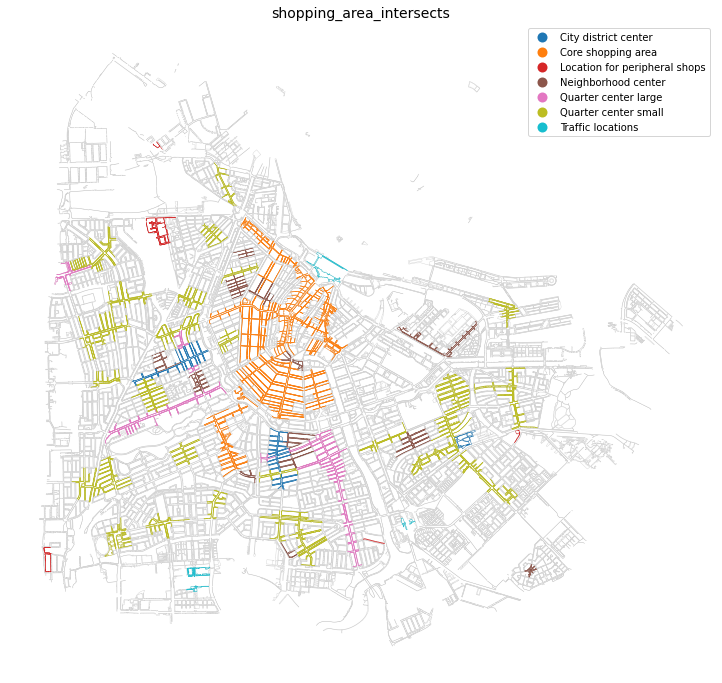

In [65]:
# street segments intersect with shoping areas
f, ax = plt.subplots(1, figsize=(24, 12))
ax.set_axis_off()
feature = 'shopping_area_intersects'
ax.set_title(feature, fontsize=14)
base = vehicle_parking.set_geometry('geometry_line').plot(linewidth = 0.4, ax=ax, color = 'lightgrey')
ax = vehicle_parking.set_geometry('geometry_line').loc[vehicle_parking[feature] != 'None'].plot(linewidth = 0.4, ax=base, column = feature, legend = True)
plt.show() 

**Merge with function mix (land use)**

In [40]:
vehicle_parking_function_mix = gpd.sjoin_nearest(vehicle_parking.to_crs({'init': 'epsg:32631'}), function_mix[['geometry','WON','WRK','VZN','function_category','CAT','WON_PERC','VZN_PERC','WRK_PERC']].to_crs({'init': 'epsg:32631'}), how='left', max_distance=100)
vehicle_parking = vehicle_parking_function_mix.drop_duplicates(subset=['section_2018', 'year'], keep='first')
vehicle_parking.drop(['index_right'], axis=1, inplace=True)
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((630390.484 5802348.362, 630390.491 5...   
1         12744  POLYGON ((632046.733 5801394.876, 632044.880 5...   
2         21603  POLYGON ((627892.631 5800718.547, 627890.284 5...   
3         34596  POLYGON ((624643.263 5804586.620, 624641.268 5...   
4         15807  POLYGON ((628799.981 5800877.938, 628799.989 5...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

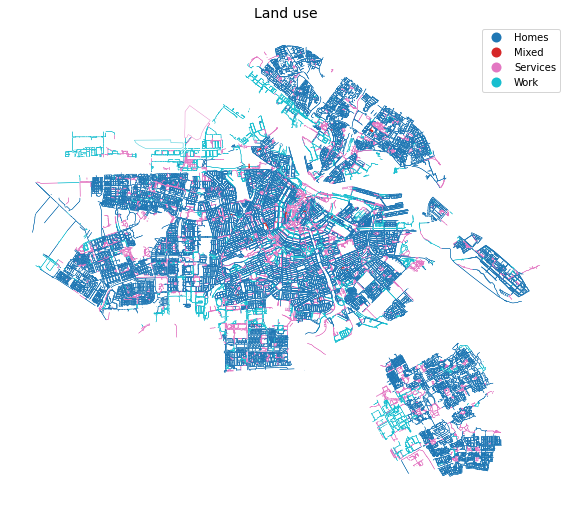

In [117]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_axis_off()
ax.set_title("Land use", fontsize=14)
ax = vehicle_parking[vehicle_parking.year==2021].set_geometry('geometry_line').plot(linewidth = 0.4, ax=ax, column = 'function_category', legend = True)
plt.show()

**Merge with sidewalk data**

In [42]:
vehicle_parking_sidewalks = gpd.sjoin(vehicle_parking, sidewalks[['full_width', 'obstacle_free_width', 'geometry']].to_crs({'init': 'epsg:32631'}), how='left')
vehicle_parking = vehicle_parking_sidewalks.drop_duplicates(subset=['section_2018','year'], keep='first')
vehicle_parking.drop(['index_right'], axis=1, inplace=True)
vehicle_parking.head()

section_2018                                           geometry  \
0         13793  POLYGON ((630390.484 5802348.362, 630390.491 5...   
1         12744  POLYGON ((632046.733 5801394.876, 632044.880 5...   
2         21603  POLYGON ((627892.631 5800718.547, 627890.284 5...   
3         34596  POLYGON ((624643.263 5804586.620, 624641.268 5...   
4         15807  POLYGON ((628799.981 5800877.938, 628799.989 5...   

                 street  year day_part  bike_inside  bike_outside  \
0            Iepenplein  2019   middag          5.0          17.0   
1  Robert Kochplantsoen  2019   middag         44.0           3.0   
2       Beethovenstraat  2019   middag          0.0           0.0   
3                   NaN  2019      NaN          NaN           NaN   
4           Europaplein  2019   middag         17.0           0.0   

   cap_bike_inside  cap_brokenup_inside  cap_private_inside  capacity_inside  \
0              6.0                  0.0                 0.0              6.0   
1              0.0                  0.0                55.0             55.0   
2              0.0                  0.0                 0.0              0.0   
3              NaN                  NaN                 NaN              NaN   
4            178.0                  0.0                 0.0            178.0   

   cargo_bike_inside  cargo_bike_outside  fourwheeler_inside  \
0                1.0                 0.0                 0.0   
1                0.0                 0.0                 0.0   
2                0.0                 0.0                 0.0   
3                NaN                 NaN                 NaN   
4                0.0                 0.0                 0.0   

   fourwheeler_outside  moped_blue_inside  moped_blue_outside  \
0                  0.0                0.0                 1.0   
1                  0.0                0.0                 0.0   
2                  0.0                0.0                 0.0   
3                  NaN                NaN                 NaN   
4                  0.0                0.0                 0.0   

   moped_yellow_inside  moped_yellow_outside  motor_inside  motor_outside  \
0                  0.0                   1.0           0.0            0.0   
1                  2.0                   1.0           0.0            0.0   
2                  0.0                   0.0           0.0            0.0   
3                  NaN                   NaN           NaN            NaN   
4                  0.0                   0.0           0.0            0.0   

   occupancy_inside  occupancy_outside  occupancy_motorized_inside  \
0               6.0               19.0                         0.0   
1              46.0                4.0                         2.0   
2               0.0                0.0                         0.0   
3               NaN                NaN                         NaN   
4              17.0                0.0                         0.0   

   occupancy_motorized_outside  occupancy_nonmotorized_inside  \
0                          2.0                            6.0   
1                          1.0                           44.0   
2                          0.0                            0.0   
3                          NaN                            NaN   
4                          0.0                           17.0   

   occupancy_nonmotorized_outside  stock_inside  stock_outside  cap_bike  \
0                            17.0           0.0            0.0       6.0   
1                             3.0           0.0            0.0       0.0   
2                             0.0           0.0            0.0       0.0   
3                             NaN           NaN            NaN       NaN   
4                             0.0           0.0            0.0     178.0   

   cap_brokenup  cap_private  bike  moped_yellow  moped_blue  cargo_bike  \
0           0.0          0.0  22.0           1.0         1.0         1.0   
1           0.0         55

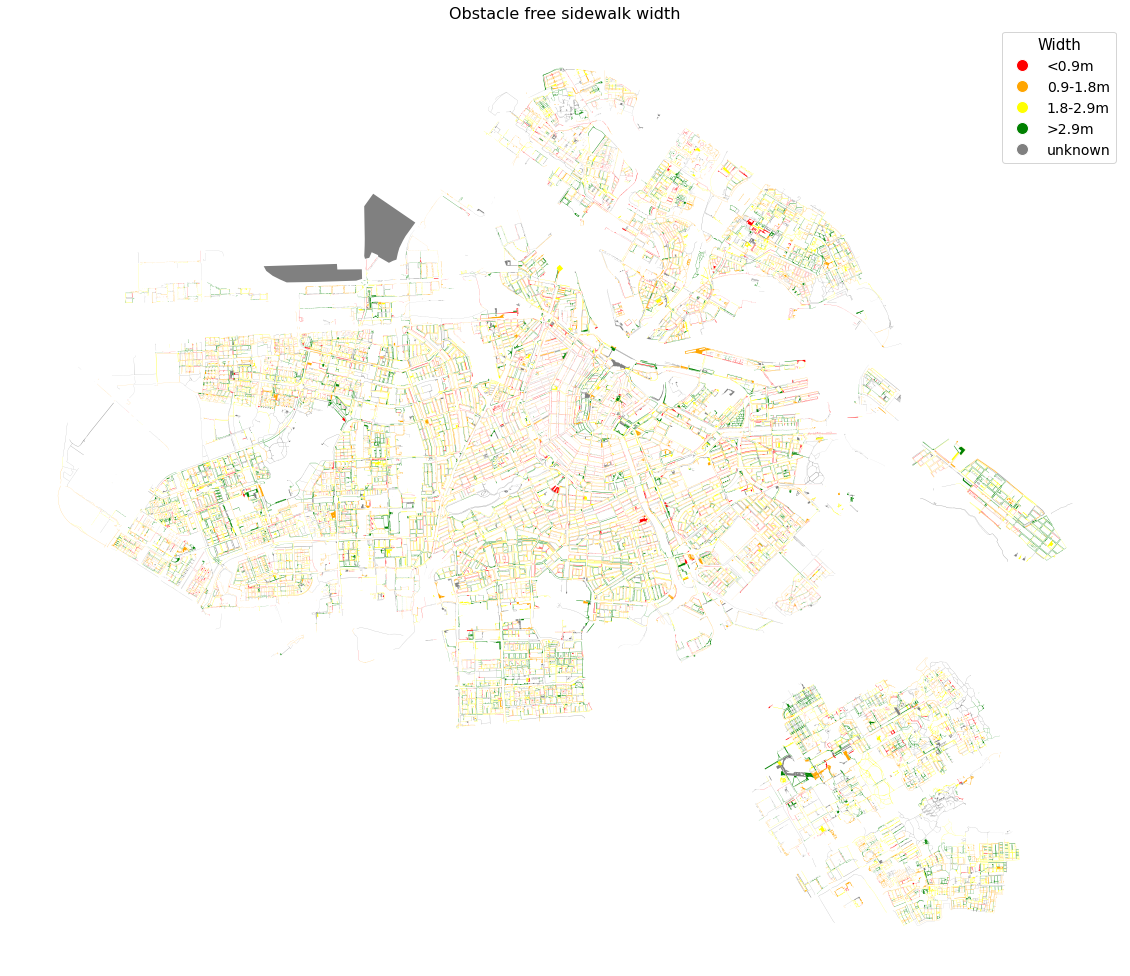

In [43]:
# Plot the sidewalk width

colorPalette = {'<0.9m': 'red',
               '0.9-1.8m': 'orange',
               '1.8-2.9m': 'yellow',
               '>2.9m' : 'green',
               'unknown' : 'gray'}
fig, ax = plt.subplots(figsize=(20, 20))

for ctype, data in vehicle_parking[vehicle_parking.year==2021].groupby('obstacle_free_width'):
    # Define the color for each group using the dictionary
    color = colorPalette[ctype]

    # Plot each group using the color defined above
    data.plot(color=color,
                      ax=ax,
                      label=ctype,
                      linewidth = 0.4,
                      aspect=1)
    
ax.set_title("Obstacle free sidewalk width", fontsize=16)
ax.set_axis_off()

legend_elements = [Line2D([0], [0], marker='o', color='w', label='<0.9m',
                              markerfacecolor='red', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='0.9-1.8m',
                              markerfacecolor='orange', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='1.8-2.9m',
                              markerfacecolor='yellow', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='>2.9m',
                              markerfacecolor='green', markersize=12),
                      Line2D([0], [0], marker='o', color='w', label='unknown',
                              markerfacecolor='gray', markersize=12)]

ax.legend(handles=legend_elements, title='Width',prop={'size': 14}, title_fontsize=15)
plt.show()

### **5 Save the data**

In [45]:
vehicle_parking.drop('geometry_line', axis=1, inplace = True)

In [46]:
vehicle_parking_with_neighborhood_2021 = vehicle_parking[vehicle_parking.year == 2021]
vehicle_parking_with_neighborhood_2020 = vehicle_parking[vehicle_parking.year == 2020]
vehicle_parking_with_neighborhood_2019 = vehicle_parking[vehicle_parking.year == 2019]

print(vehicle_parking_with_neighborhood_2021.shape)
print(vehicle_parking_with_neighborhood_2020.shape)
print(vehicle_parking_with_neighborhood_2019.shape)

(32691, 374)
(32647, 374)
(32653, 374)


In [47]:
vehicle_parking_with_neighborhood_2021.to_csv(main_path + "vehicle_parking_with_neighborhood_2021.csv", index = False)
vehicle_parking_with_neighborhood_2020.to_csv(main_path + "vehicle_parking_with_neighborhood_2020.csv", index = False)
vehicle_parking_with_neighborhood_2019.to_csv(main_path + "vehicle_parking_with_neighborhood_2019.csv", index = False)